# Application MHMM: Dedicated for the resuts in the ICCR Abstract

This notbook serves as a walktrough for using the lymphatic mixture model, which extends the HMM.

This includes:
1. Data Loading and enhancing
2. Optional Prevalence Plots
3. Independent Sampling for the given locations
4. Init and fit of the mixture components
5. Predictions using the mixture model


In [3]:
# First, add the parent path 
import os, sys

current_working_directory = os.getcwd()
# Get the parent directory
parent_directory = os.path.dirname(current_working_directory)
# Add the parent directory to sys.path
sys.path.append(parent_directory)
sys.path.append(parent_directory + "/core")



In [34]:
# Some imports 
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib as mpl
import pandas as pd
import logging
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import corner

import warnings
from lyscripts.sample import sample_from_model

from core.util_2 import (
    set_size,
    usz_colors,
    edge_colors,
    create_models,
    create_prev_vectors,
    convert_lnl_to_filename,
    plot_prevalences_icd,
    plot_prevalences_categories,
    reverse_dict,
    load_data,
    enhance_data,
    COLORS,
    plot_histograms
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Set styling params and initialize the logger
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("../styles/mplstyle_rl.txt")

logger = logging.getLogger(__name__)
logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )

In [6]:
usz_blue = "#005ea8"
usz_blue_border = "#2387D5"
usz_green = "#00afa5"
usz_green_border = "#30DFD5"
usz_red = "#ae0060"
usz_red_border = "#FB4EAE"
usz_orange = "#f17900"
usz_orange_border = "#F8AB5C"
usz_gray = "#c5d5db"
usz_gray_border = "#DFDFDF"
usz_colors = [usz_blue, usz_green, usz_red, usz_orange, usz_gray]
edge_colors = [
    usz_blue_border,
    usz_green_border,
    usz_red_border,
    usz_orange_border,
    usz_gray_border,
]


## 0 Model Setup

First, we set up directories and define properties for the lymph model we will to use.

In [7]:
# **Some Definitions**

# Set a name for the run.
NAME = "abstract_oc_op"
PLOT_PATH = Path(f"figures/{NAME}/")
SAMPLE_PATH = Path(f"samples/{NAME}/")

# Create the directories
PLOT_PATH.mkdir(parents=True, exist_ok=True)
SAMPLE_PATH.mkdir(parents=True, exist_ok=True)

In [8]:
# Set the graph which we want to use
graph = {
        ("tumor", "primary"): ["I", "II", "III", "IV"],
        ("lnl", "I"): ["II"],
        ("lnl", "II"): ["III"],
        ("lnl", "III"): ["IV"],
        ("lnl", "IV"): [],
    }
lnls_full = graph["tumor", "primary"]

# Define wether we want to include t-stages or not.
ignore_t = True
if ignore_t:
    convert_t_stage = {0: "all", 1: "all", 2: "all", 3: "all", 4: "all"}
else:
    convert_t_stage = {0: "early", 1: "early", 2: "early", 3: "late", 4: "late"}

t_stages = list(set(convert_t_stage.values()))


# 1. Load the Data and create some nice plots

### 1.1 Either load real data or create a synthetic dataset

In [9]:
# Either use external data or use synth data
data_source = "REAL" # "SYNTH" | "REAL"

In [10]:
if data_source == "REAL":
    # Load the data.
    datasets_names = [
            "2022_CLB_multisite_enhanced.csv",
            "2022_CLB_oropharynx_enhanced.csv",
            "2022-ISB-multisite_enhanced.csv",
            "2023-usz-hypopharynx-larynx_enhanced.csv",
            "2022-USZ-oropharynx_enhanced.csv",
            "2023-hvh-oropharynx_enhanced.csv"
        ]
    dataset = load_data(datasets_names)
    dataset = enhance_data(dataset, convert_t_stage)
    dataset.head()

Succesfully loaded 1786 Patients


In [11]:
# .. or create a new synthetic dataset using a config.
if data_source == "SYNTH":
    from data.create_subsites_datasets import create_synth_data_by_config


    config = {
                "name": "synth_s1_s2_n0",
                "n": [200, 200, 200],
                "graph": {
                    ("tumor", "primary"): ["I", "II", "III"],
                    ("lnl", "I"): [],
                    ("lnl", "II"): ["I", "III"],
                    ("lnl", "III"): [],
                },
                "params": [
                    [0.3, 0.0, 0.3, 0.0, 0.0],
                    [0.0, 0.6, 0.6, 0.0, 0.0],
                    [0.01, 0.01, 0.01, 0.01, 0.01],
                ],
                "locations": ["S1", "S2", "S3"],
                "t_dist": {"early": 1, "late": 0},
            }
    dataset = create_synth_data_by_config(plot= False, save_dataset= False, **config)
    dataset = enhance_data(dataset, convert_t_stage)


### 1.2 Definition what subsite data we will use

In [12]:
# Select which locations you want to include. All ICD from that locatoin will be included.

# location_to_include = dataset["tumor","1","location"].unique()
location_to_include = ["oral cavity", "oropharynx"]

# Icd codes in locations which you want to exlude (maybe those with low amount of patients).
icds_to_neglect = ["C00", "C08"]


In [13]:
# Now we create some dictionaries which are used later on, as maps from icd to dataset masks.

# Create a mask for the patients for each locations
loc_to_mask = {
    loc: dataset["tumor"]["1"]["location"] == loc for loc in location_to_include
}

# Location to icd dict
loc_to_icds_full = {
    loc: dataset[loc_to_mask[loc]]["tumor", "1", "majorsubsites"].unique()
    for loc in location_to_include
}
# Filtering out unwanted ICDs
loc_to_icds_model = {
    k: [icd for icd in v if icd not in icds_to_neglect]
    for k, v in loc_to_icds_full.items()
}

for k, v in loc_to_icds_model.items():
    print(f"In tumor location {k}: {v}")

# Dictionary for the relation icd - location
icd_to_loc_model = reverse_dict(loc_to_icds_model)

# For each icd, create a mask for the corresponding patients
icd_to_masks = {}
for icd in icd_to_loc_model.keys():
    icd_to_masks[icd] = dataset["tumor", "1", "majorsubsites"] == icd



In tumor location oral cavity: ['C02', 'C03', 'C04', 'C05', 'C06']
In tumor location oropharynx: ['C01', 'C09', 'C10']


### 1.3 Create Beautiful Plots



In [14]:
# Color mapping for locations
color_map = {loc: usz_colors[i] for i, loc in enumerate(location_to_include)}

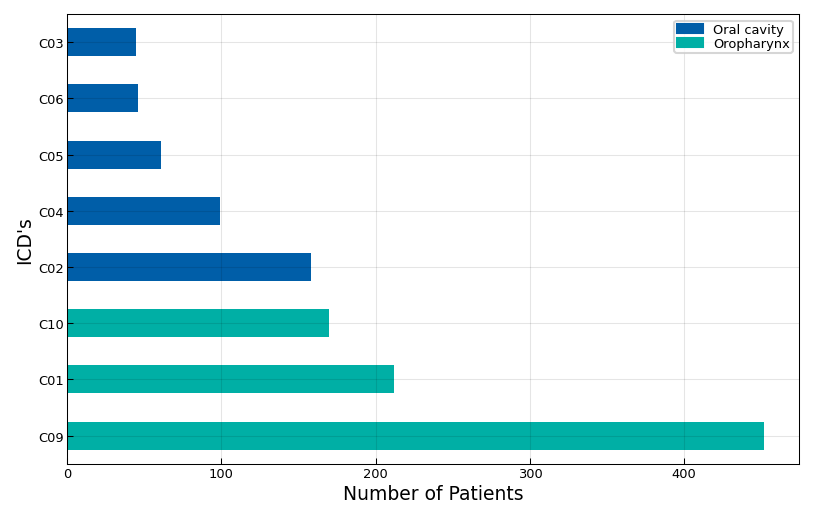

2024-01-18 09:12:45,104 - __main__ - INFO - Created n_patients_icd figure in figures/abstract_oc_op


In [15]:
# Counting the occurrence of each ICD code
icd_value_counts_sorted = dataset[
    np.logical_or.reduce(list(icd_to_masks.values()))
]["tumor", "1", "majorsubsites"].value_counts()

# Assigning colors to each ICD based on its location
colors = [
    color_map[icd_to_loc_model[icd]] for icd in icd_value_counts_sorted.keys()
]

# labels = [icd_to_loc_model[icd] for icd in icd_value_counts_sorted.keys()]

fig, ax = plt.subplots(1, figsize=set_size("full"))
icd_value_counts_sorted.plot(kind="barh", ax=ax, color=colors)

legend_elements = []
for loc in location_to_include:
    legend_elements.append(
        mpatches.Patch(color=color_map[loc], label=loc.capitalize())
    )
ax.set_xlabel("Number of Patients")
ax.set_ylabel("ICD's")
ax.legend(handles=[e for e in legend_elements])
fig.savefig(PLOT_PATH / "n_patients_icd.png")
fig.savefig(PLOT_PATH / "n_patients_icd.svg")
plt.show()

logger.info(f"Created n_patients_icd figure in {PLOT_PATH}")

Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.093505039193729{'I': None, 'II': True, 'III': None, 'IV': None}: 0.5190369540873461{'I': None, 'II': None, 'III': True, 'IV': None}: 0.2625979843225084{'I': None, 'II': None, 'III': None, 'IV': True}: 0.07726763717805152
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.20050761421319796{'I': None, 'II': True, 'III': None, 'IV': None}: 0.2918781725888325{'I': None, 'II': None, 'III': True, 'IV': None}: 0.12436548223350254{'I': None, 'II': None, 'III': None, 'IV': True}: 0.03807106598984772
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.08163265306122448{'I': None, 'II': True, 'III': None, 'IV': None}: 0.7332361516034985{'I': None, 'II': None, 'III': True, 'IV': None}: 0.31486880466472306{'I': None, 'II': None, 'III': None, 'IV': True}: 0.09037900874635568


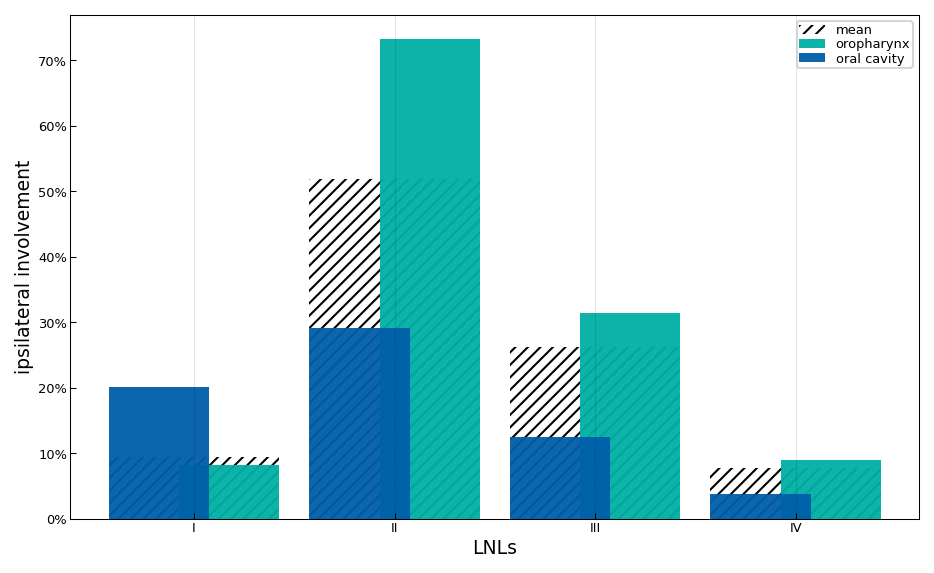

2024-01-18 09:12:45,771 - __main__ - INFO - Created prevalence figures in figures/abstract_oc_op


In [16]:
# Compare the observed involment for each tumor location
   
# Here we do not consider early and late

prev_mean = create_prev_vectors(
    dataset,
    lnls_full,
    t_stages=t_stages,
    full_involvement=True,
    plot=False,
)

prev_loc = [
    create_prev_vectors(
        dataset[loc_to_mask[loc]],
        lnls_full,
        t_stages=t_stages,
        full_involvement=True,
    )
    for loc in location_to_include
]

plot_prevalences_categories(
    prev_loc,
    prev_mean,
    lnls_full,
    location_to_include,
    list(color_map.values()),
    edge_colors,
    save_name=PLOT_PATH
    / f"prev_categories_{convert_lnl_to_filename(lnls_full)}.png",
)

# prev_loc.append(prev_mean)
# prev_loc_df = pd.DataFrame(
#     np.round(np.array(prev_mean) * 100, 2),
#     index=[*location_to_include, loc.capitalize()],
#     columns=[str(s) for s in lnls_full],
# ).T
# prev_loc_df.to_csv(
#     PLOT_PATH / f"prev_categories_{convert_lnl_to_filename(lnls_full)}.csv"
# )
plt.show()
logger.info(f"Created prevalence figures in {PLOT_PATH}")



Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.20050761421319796{'I': None, 'II': True, 'III': None, 'IV': None}: 0.2918781725888325{'I': None, 'II': None, 'III': True, 'IV': None}: 0.12436548223350254{'I': None, 'II': None, 'III': None, 'IV': True}: 0.03807106598984772
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.13291139240506328{'I': None, 'II': True, 'III': None, 'IV': None}: 0.34177215189873417{'I': None, 'II': None, 'III': True, 'IV': None}: 0.16455696202531644{'I': None, 'II': None, 'III': None, 'IV': True}: 0.06329113924050633
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.37777777777777777{'I': None, 'II': True, 'III': None, 'IV': None}: 0.2{'I': None, 'II': None, 'III': True, 'IV': None}: 0.0{'I': None, 'II': None, 'III': None, 'IV': True}: 0.0
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.2222222222222222{'I': None, 'II': True, 'III': None, 'IV': None}: 0.23232323232323232{'I': None, 'II': None, 'III'

2024-01-18 09:12:46,382 - __main__ - INFO - Created prevalence figures in figures/abstract_oc_op


Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.08163265306122448{'I': None, 'II': True, 'III': None, 'IV': None}: 0.7332361516034985{'I': None, 'II': None, 'III': True, 'IV': None}: 0.31486880466472306{'I': None, 'II': None, 'III': None, 'IV': True}: 0.09037900874635568
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.10377358490566038{'I': None, 'II': True, 'III': None, 'IV': None}: 0.8443396226415094{'I': None, 'II': None, 'III': True, 'IV': None}: 0.35377358490566035{'I': None, 'II': None, 'III': None, 'IV': True}: 0.09433962264150944
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.09070796460176991{'I': None, 'II': True, 'III': None, 'IV': None}: 0.7300884955752213{'I': None, 'II': None, 'III': True, 'IV': None}: 0.29646017699115046{'I': None, 'II': None, 'III': None, 'IV': True}: 0.10398230088495575
Prev Vector: {'I': True, 'II': None, 'III': None, 'IV': None}: 0.1{'I': None, 'II': True, 'III': None, 'IV': None}: 0.617647058823529

2024-01-18 09:12:46,759 - __main__ - INFO - Created prevalence figures in figures/abstract_oc_op


Prev Vector: [0.5406091370558376, 0.09390862944162437, 0.1548223350253807, 0.0583756345177665, 0.04060913705583756, 0.01015228426395939, 0.030456852791878174, 0.027918781725888325, 0.015228426395939087, 0.0025380710659898475, 0.0025380710659898475, 0.0025380710659898475, 0.0, 0.0, 0.01015228426395939, 0.005076142131979695]
Prev Vector: [0.21428571428571427, 0.0029154518950437317, 0.4139941690962099, 0.03206997084548105, 0.03935860058309038, 0.0014577259475218659, 0.17346938775510204, 0.030612244897959183, 0.004373177842565598, 0.0, 0.014577259475218658, 0.0014577259475218659, 0.0029154518950437317, 0.0, 0.05393586005830904, 0.013119533527696793]


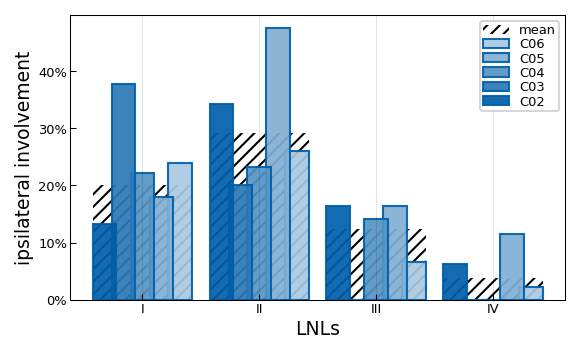

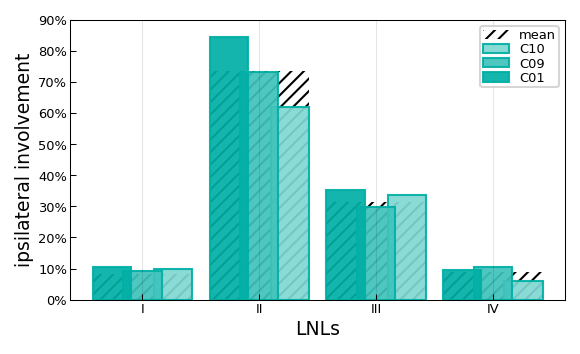

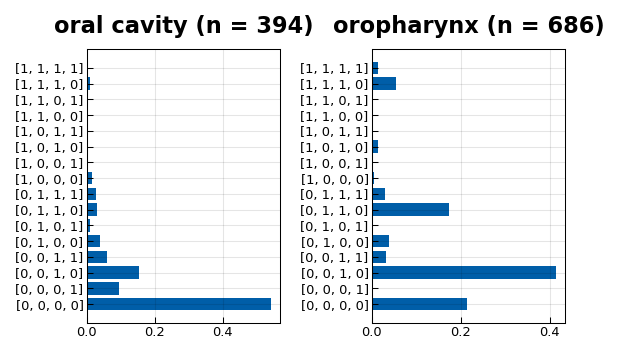

2024-01-18 09:12:48,281 - __main__ - INFO - Created prevalence figures in figures/abstract_oc_op


In [17]:
# .. and for each ICD code selected.

# For every location, plot the prevalences of each corresponding icd code. 
if any(len(loc_to_icds_model[loc]) > 1 for loc in location_to_include):
    for loc in location_to_include:
    # Check if the location has more than one icd code.
   
        # Here we do not consider early and late
        prev_loc = create_prev_vectors(
            dataset[loc_to_mask[loc]],
            lnls_full,
            t_stages=t_stages,
            full_involvement=True,
            plot=False,
        )
        prev_loc_icds = [
            create_prev_vectors(
                dataset[icd_to_masks[icd]],
                lnls_full,
                t_stages=t_stages,
                full_involvement=True,
            )
            for icd in loc_to_icds_model[loc]
        ]

        plot_prevalences_icd(
            prev_loc_icds,
            prev_loc,
            lnls_full,
            loc_to_icds_model[loc],
            color_map[loc],
            save_name=PLOT_PATH
            / f"prev_{loc}_{convert_lnl_to_filename(lnls_full)}.png",
        )

        prev_loc_icds.append(prev_loc)
        prev_loc_df = pd.DataFrame(
            np.round(np.array(prev_loc_icds) * 100, 2),
            index=[*loc_to_icds_model[loc], loc.capitalize()],
            columns=[str(s) for s in lnls_full],
        ).T
        prev_loc_df.to_csv(
            PLOT_PATH / f"prev_{loc}_{convert_lnl_to_filename(lnls_full)}.csv"
        )
        logger.info(f"Created prevalence figures in {PLOT_PATH}")


# just plot prev in one single plot
# Check that the data is correct
fig, axs = plt.subplots(
    1,
    len(location_to_include),
    figsize=set_size(width="single"),
    tight_layout=True,
)
for i, loc in enumerate(location_to_include):
    create_prev_vectors(
        dataset[loc_to_mask[loc]],
        lnls_full,
        t_stages=t_stages,
        plot=True,
        title=loc,
        ax=axs[i],
    )
plt.show()
fig.savefig(PLOT_PATH / f"prev_{convert_lnl_to_filename(lnls_full)}.png")
logger.info(f"Created prevalence figures in {PLOT_PATH}")


## 2. Independent Models

In [18]:
def log_prob_fn(theta: np.ndarray | list) -> float:
    global MODEL
    for t in theta:
        if t < 0 or 1 < t:
            return -10000
    llh = MODEL.likelihood(given_param_args=theta, log=True)
    if np.isnan(llh):
        llh = -10000
    if np.isinf(llh):
        llh = -10000
    return llh

In [19]:
indep_nburnin = 250
indep_nstep = 500
params_sampling = {
    "walkers_per_dim": 20,
    "nsteps": indep_nstep,
    "thin_by": 1,
    "nburnin": indep_nburnin,
}

# We need global variables, such that the likelihood functions work
global MODEL

models_loc = {}
for loc in location_to_include: 
    model = create_models(1, graph, ignore_t_stage=ignore_t)
    model.load_patient_data(
        dataset[loc_to_mask[loc]], mapping=lambda x: convert_t_stage[x], side="ipsi"
    )
    models_loc[loc] = model
    # n_params = len(model.get_params())
    sample_name = Path(
        f"samples_ind_{loc}_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    output_dir = SAMPLE_PATH / sample_name
    if output_dir.with_suffix(".npy").exists():
        sampling_results = np.load(output_dir.with_suffix(".npy"))
        logger.warning(
            f"Found samples in {output_dir}. Skipping independent model sampling. "
        )
    else:
        logger.info(f"Start independent sampling for {loc}..")
        sampling_results = sample_from_model(
            model,
            params_sampling,
            SAMPLE_PATH,
            sample_name=sample_name,
            store_as_chain=True,
        )

2024-01-18 09:12:48,383 - __main__ - WARNING - Found samples in samples/abstract_oc_op/samples_ind_oral cavity_I_to_IV_True. Skipping independent model sampling. 


2024-01-18 09:12:48,496 - __main__ - WARNING - Found samples in samples/abstract_oc_op/samples_ind_oropharynx_I_to_IV_True. Skipping independent model sampling. 


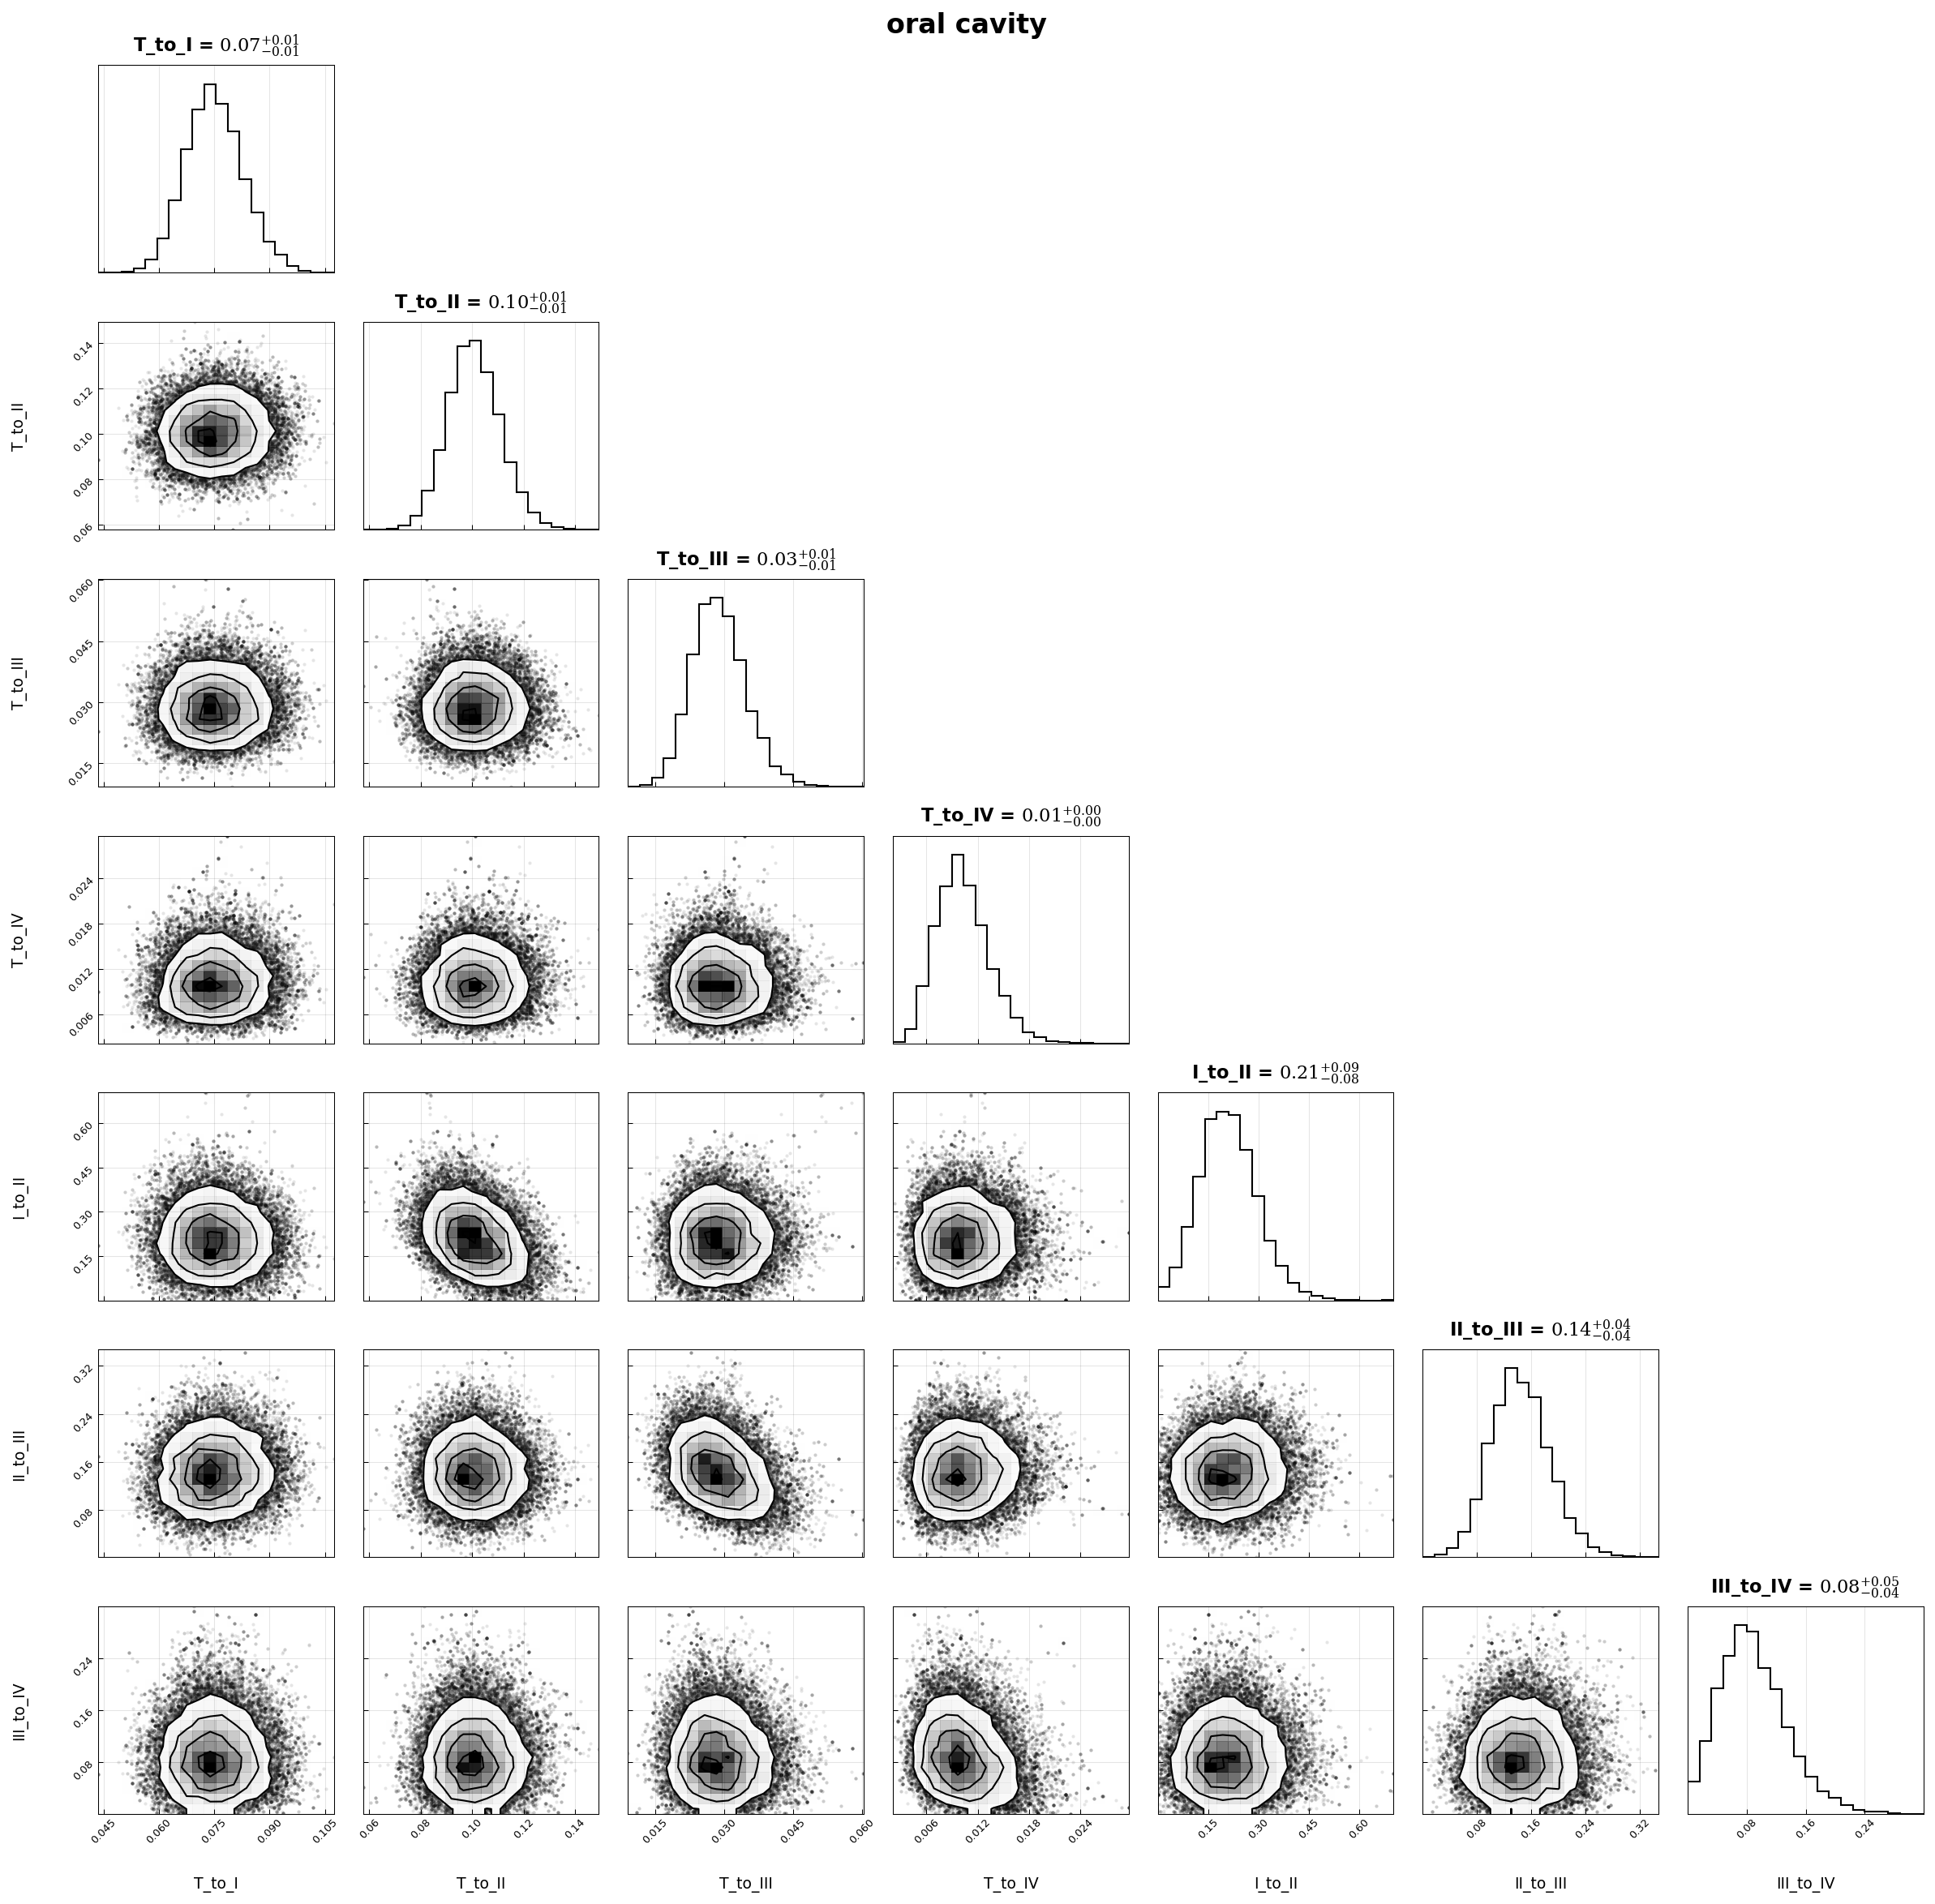

2024-01-17 18:10:01,163 - __main__ - INFO - Created corner plot for samples for oral cavity


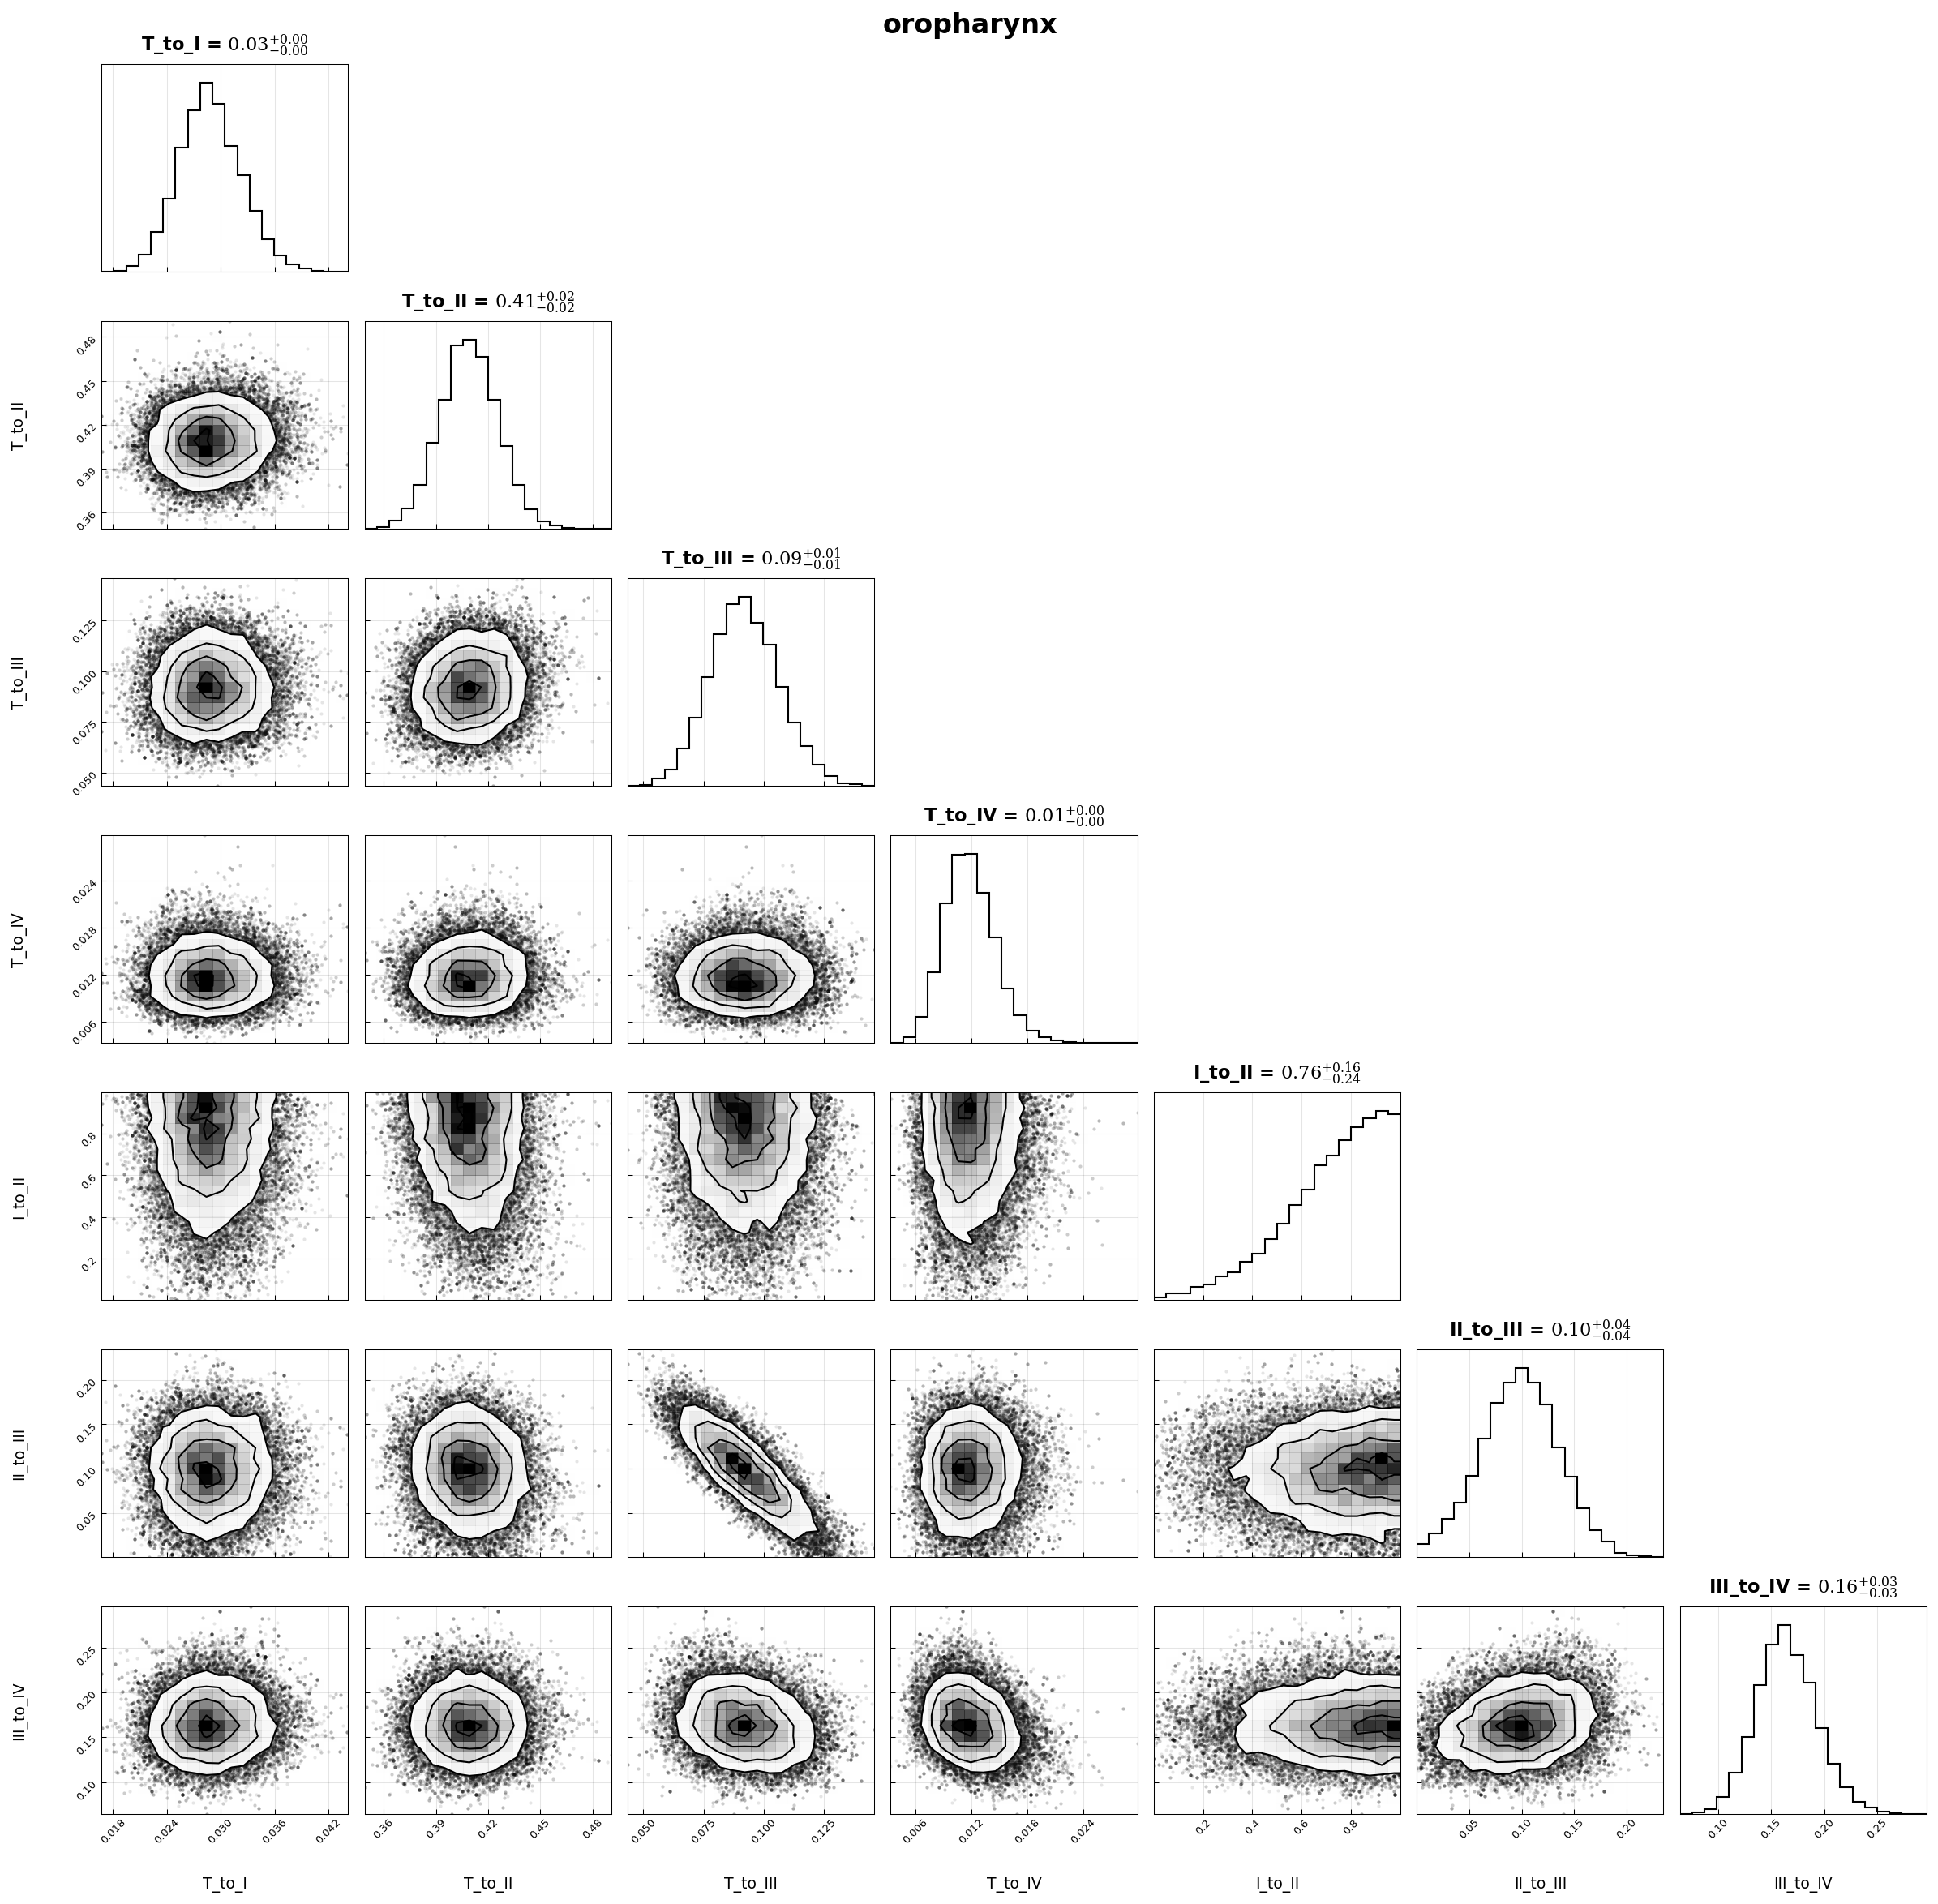

2024-01-17 18:10:08,892 - __main__ - INFO - Created corner plot for samples for oropharynx


In [39]:
# For each location, generate the corner plot
for loc in location_to_include:
    # The sample name has to be the same as defined in sampling.
    sample_name = (
        f"samples_ind_{loc}_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    sample_dir = SAMPLE_PATH / sample_name
    samples = np.load(sample_dir.with_suffix(".npy"))

    # Ugly, may change to more robust function (e.g. get_lables)
    label_ts = [
        t.replace("primary", "T").replace("_spread", "")
        for t in models_loc[loc].get_params(as_dict=True).keys()
    ]
    fig = corner.corner(
        samples,
        labels=label_ts,
        show_titles=True,
    )
    fig.suptitle(f"{loc}", fontsize=16)
    fig.tight_layout()
    fig.savefig(PLOT_PATH / f"corner_ind_{loc}.png")
    plt.show()
    logger.info(f"Created corner plot for samples for {loc}")
    

## 2.1 Create Histogram plots for some scenarios

In [40]:
# Create histogram plots if you want (includes manually change the location names etc.)
create_hist_plot = True

In [41]:
# Reload the sample chains for each locations 

# Change the names according to your specific Problem 
if create_hist_plot:
    sample_name = (
        f"samples_ind_oral cavity_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    sample_dir = SAMPLE_PATH / sample_name
    samples_oc = np.load(sample_dir.with_suffix(".npy"))

    sample_name = (
    f"samples_ind_oropharynx_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    sample_dir = SAMPLE_PATH / sample_name
    samples_op = np.load(sample_dir.with_suffix(".npy"))

In [42]:
# Create prevalence plot
if create_hist_plot:
    from core.mm_predict import _create_obs_pred_df_single
    from core.util_2 import create_states

    patterns = create_states(lnls_full, total_lnls=True)

    # Create the data which is used for the hist plots
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        df_oc, oc_list = _create_obs_pred_df_single(samples_oc, models_loc["oral cavity"], dataset[loc_to_mask["oral cavity"]], patterns, lnls_full, n_samples = 400)
        df_c05, c05_list = _create_obs_pred_df_single(samples_oc, models_loc["oral cavity"], dataset[icd_to_masks["C05"]], patterns, lnls_full, n_samples = 400)
        df_op, op_list = _create_obs_pred_df_single(samples_op, models_loc["oral cavity"], dataset[loc_to_mask["oropharynx"]], patterns, lnls_full, n_samples = 400)



Set up figure
Plotted 3 histograms


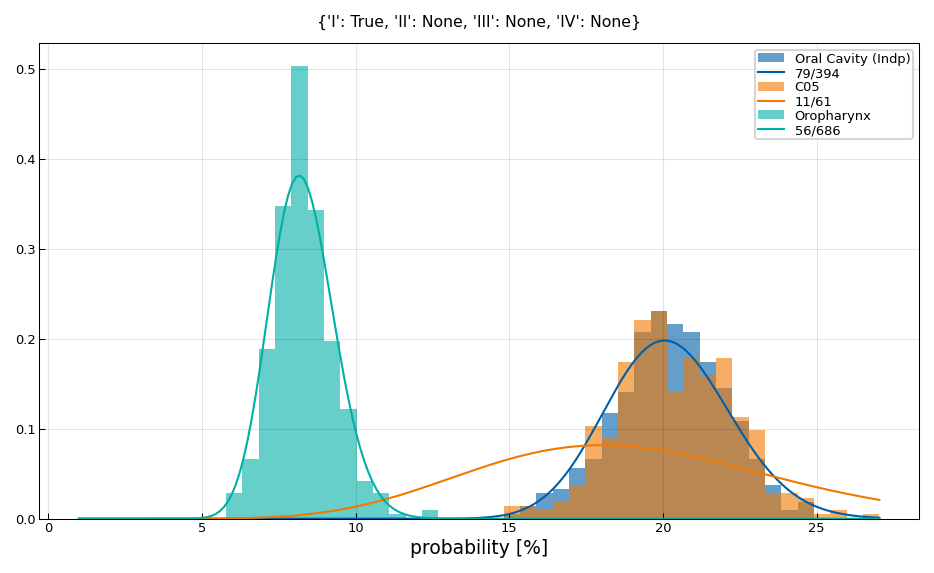

In [44]:
from core.util_2 import plot_histograms

loc = 'OC_1_2'
bins =50
single_line = False
t_stage = 'all'
data = {'Oral Cavity (Indp)': oc_list[3][t_stage], 'C05': c05_list[3][t_stage], 'Oropharynx': op_list[3][t_stage]}
# states_for_hists = [
#     "{'III': False, 'II': False, 'I': False}",
#     "{'III': False, 'II': False, 'I': True}",
#     "{'III': False, 'II': True, 'I': False}",
#     "{'III': True, 'II': True, 'I': False}"]
states_for_hists =patterns[:1]
plot_histograms(data, states_for_hists, single_line=single_line,colors = COLORS, loc=loc)

## The Mixture Model

Now we can move to the mixture model. 

### 3.1 Create the models and loads each model with patient data from a ICD code.

In [20]:
# Set number of clusters for the mixture model
n_clusters = 2
n_subpopulations = len(icd_to_masks)

# subpopulation data
subpopulation_data = [dataset[v] for v in icd_to_masks.values()]
subpopulation_labels = [l for l in icd_to_masks.keys()]

# Create the base model which will be used in the Mixture Model
lymph_model_for_mixture = create_models(1, graph, ignore_t_stage=ignore_t)

In [21]:
%load_ext autoreload
%autoreload 2
import importlib

import core.mixture_model
from core.costum_types import EMConfigType
importlib.reload(core.mixture_model)
from core.mixture_model import LymphMixtureModel

# Create a new mixture model, given a lymph model which serves as the base model for each cluster
LMM = LymphMixtureModel(lymph_model_for_mixture, n_clusters=n_clusters, n_subpopulation=n_subpopulations, name = 'LMM_abstract')
# Load the data, choose the t_stage mapping you want.
LMM.load_data(subpopulation_data, subpopulation_labels, mapping=lambda x: convert_t_stage[x])


2024-01-18 09:12:48,700 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM_abstract
2024-01-18 09:12:48,701 - core.mixture_model - INFO - Assigned C02 to supopulations with 158 patients
2024-01-18 09:12:48,702 - core.mixture_model - INFO - Assigned C03 to supopulations with 45 patients
2024-01-18 09:12:48,703 - core.mixture_model - INFO - Assigned C04 to supopulations with 99 patients
2024-01-18 09:12:48,703 - core.mixture_model - INFO - Assigned C05 to supopulations with 61 patients
2024-01-18 09:12:48,704 - core.mixture_model - INFO - Assigned C06 to supopulations with 46 patients
2024-01-18 09:12:48,705 - core.mixture_model - INFO - Assigned C01 to supopulations with 212 patients
2024-01-18 09:12:48,706 - core.mixture_model - INFO - Assigned C09 to supopulations with 452 patients
2024-01-18 09:12:48,707 - core.mixture_model - INFO - As

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Now we can check if the likelihood function works.

LMM.cluster_assignments = np.zeros(shape=(LMM.n_subpopulation * (LMM.n_clusters-1))) + 0.2
LMM.cluster_parameters = np.random.random(LMM.n_cluster_parameters)
llh = LMM.mm_hmm_likelihood()
assert llh<0
print(llh)



-5429.719665624972


In [23]:
# Now that we are sure the likelihood works, we can fit the model to the data using the fit function
#
# from IPython.display import clear_output

# First we define configs for the EM algorithm.
em_config: EMConfigType = {
    "max_steps": 20,
    "method": "DEFAULT", # INVERTED | DEFAULT (INVERTED means that during expectaion, the cluster parameters are sampled, and not the cluster assignments.)
    "verbose": False,
    "e_step": {
        "walkers_per_dim": 20,
        "nsteps": 30,
        "nburnin": 50,
        "sampler": "SIMPLE",
        "show_progress": True,
    },
    "m_step": {
        "minimize_method": "SLSQP",
        "imputation_function": lambda x: int(10 / (6) * x**1.1 + 1),
    },
    "convergence": {
        "criterion": "default",
        "default": {"lookback_period": 4, "threshold": 0.015},
    },
}

# .. and for the final MCMC sampling
mcmc_config = {
    "sampler": "SIMPLE",
    "sampling_params": {
        "walkers_per_dim": 20,
        "nsteps": 1000,
        "nburnin": 600,
    },
}

# Uncomment if you want to skip the EM sampler (=> History object will be None)
# given_cluster_assignments = [6.69227174e-01, 1.00000000e+00, 8.78621773e-01, 6.52599709e-01,
#        9.18963382e-01, 1.70623572e-11, 4.74846922e-02, 2.55384748e-01]
given_cluster_assignments = None
given_cluster_assignments = np.load("LMM_abstract/samples/final_cluster_assignments.npy")
history = LMM.fit(em_config=em_config, mcmc_config=mcmc_config, force_resampling = False, cluster_assignments = given_cluster_assignments)








2024-01-18 09:15:38,085 - core.mixture_model - INFO - Skipping EM Algortihm, since cluster assignment is already given
2024-01-18 09:15:38,088 - core.mixture_model - INFO - MCMC sampling chain found in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM_abstract/samples/mcmc_sampling_chain_1000_600.npy. Skipping Sampling.


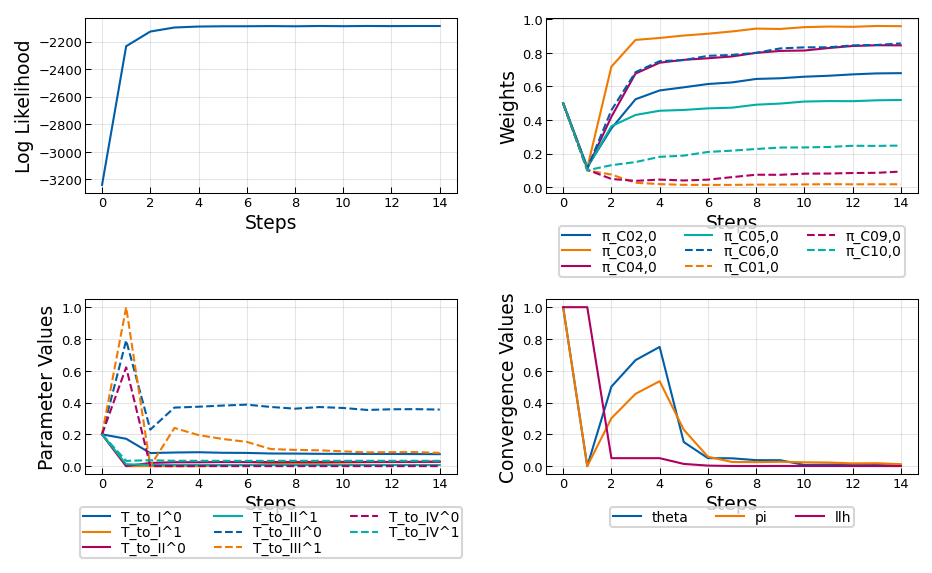

In [53]:
# Now we can check the progress of the EM algortihm by plotting the history data.
history.plot_history(LMM.subpopulation_labels, list(LMM.lymph_model.get_params(as_dict=True).keys()), LMM.n_clusters, None)

2024-01-18 09:15:48,090 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


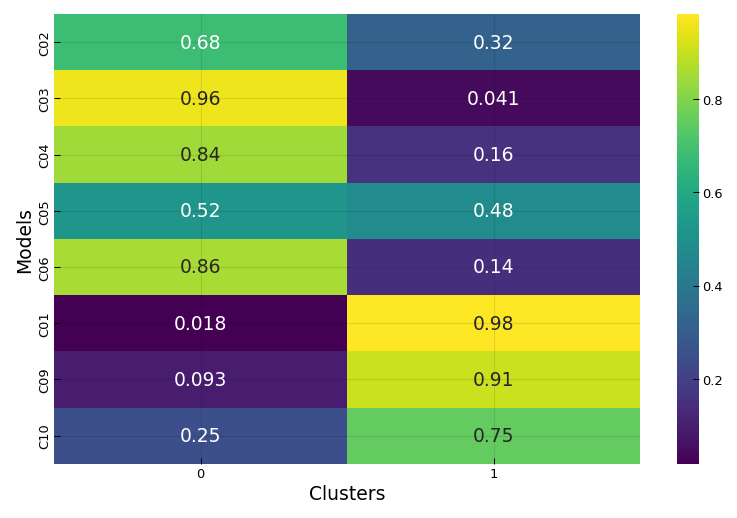

In [24]:
# Additionally, we can check the resulting cluster assignment matrix.
# TODO add other methods ["SLIDER", "FLOW"]
LMM.plot_cluster_assignment_matrix(labels=LMM.subpopulation_labels)

2024-01-17 18:24:00,813 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
2024-01-17 18:24:14,945 - core.mixture_model - INFO - Saved matplotlib figure
/Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/core/mm_plotting.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


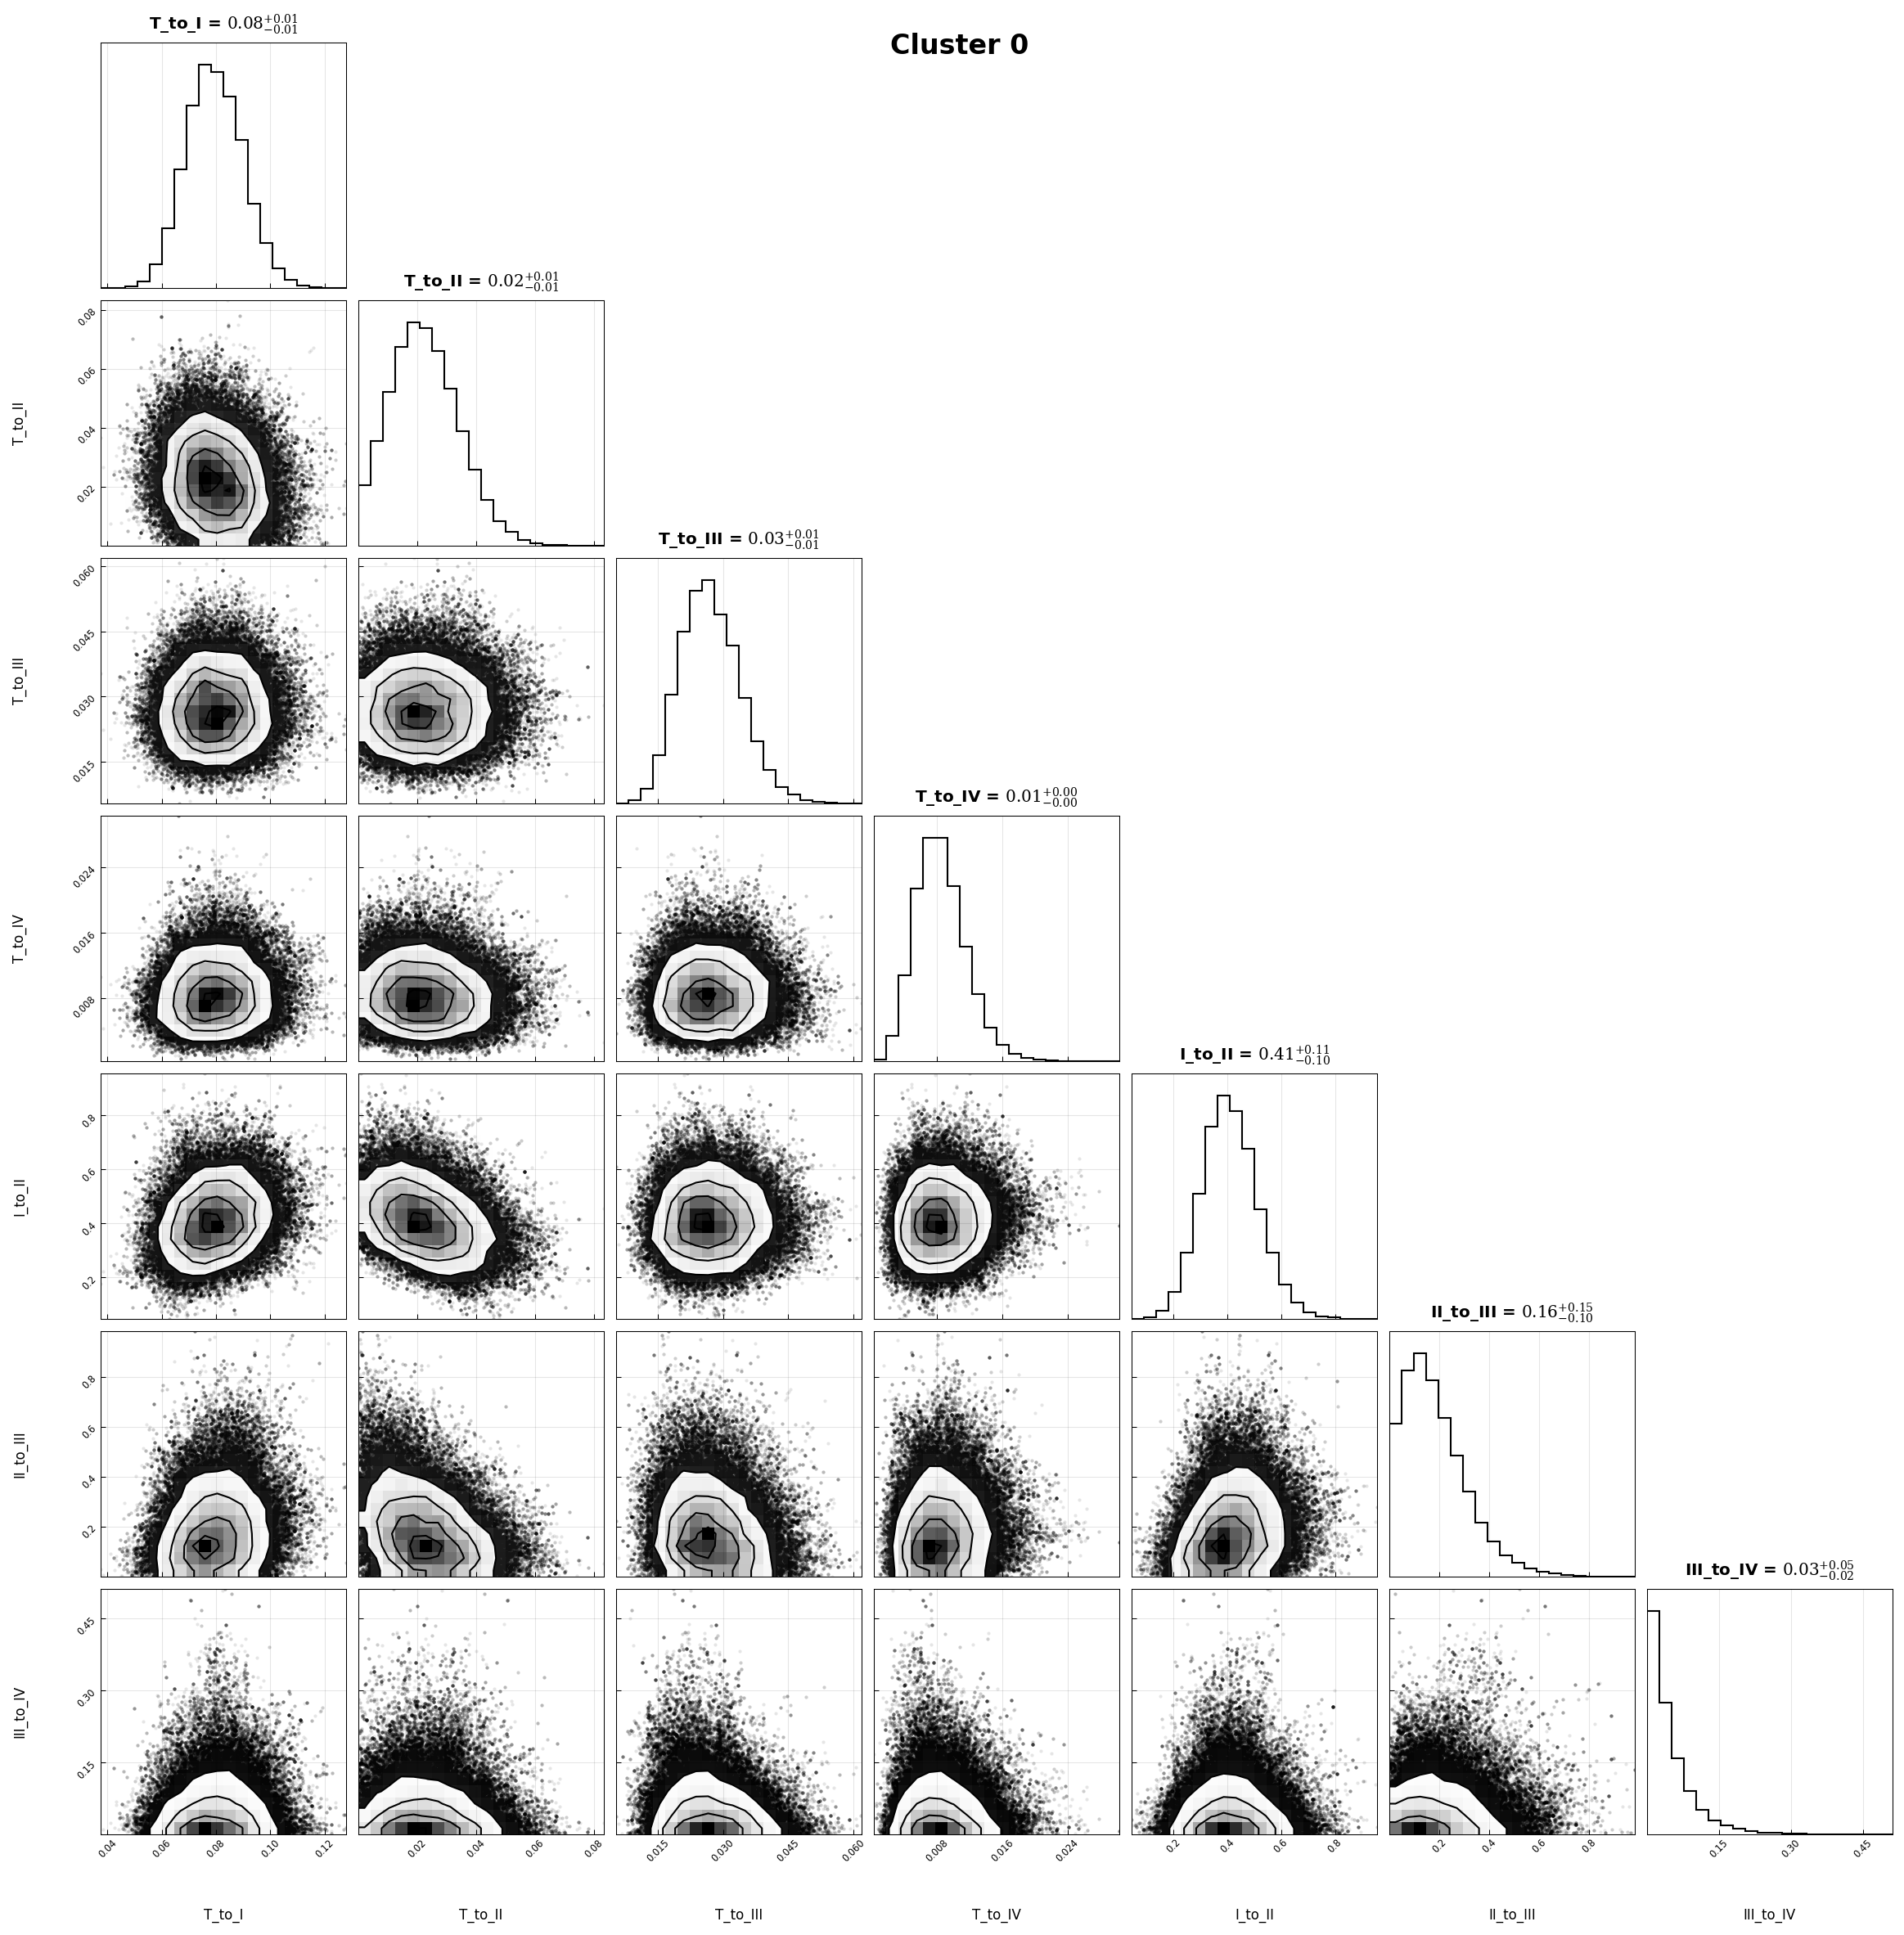

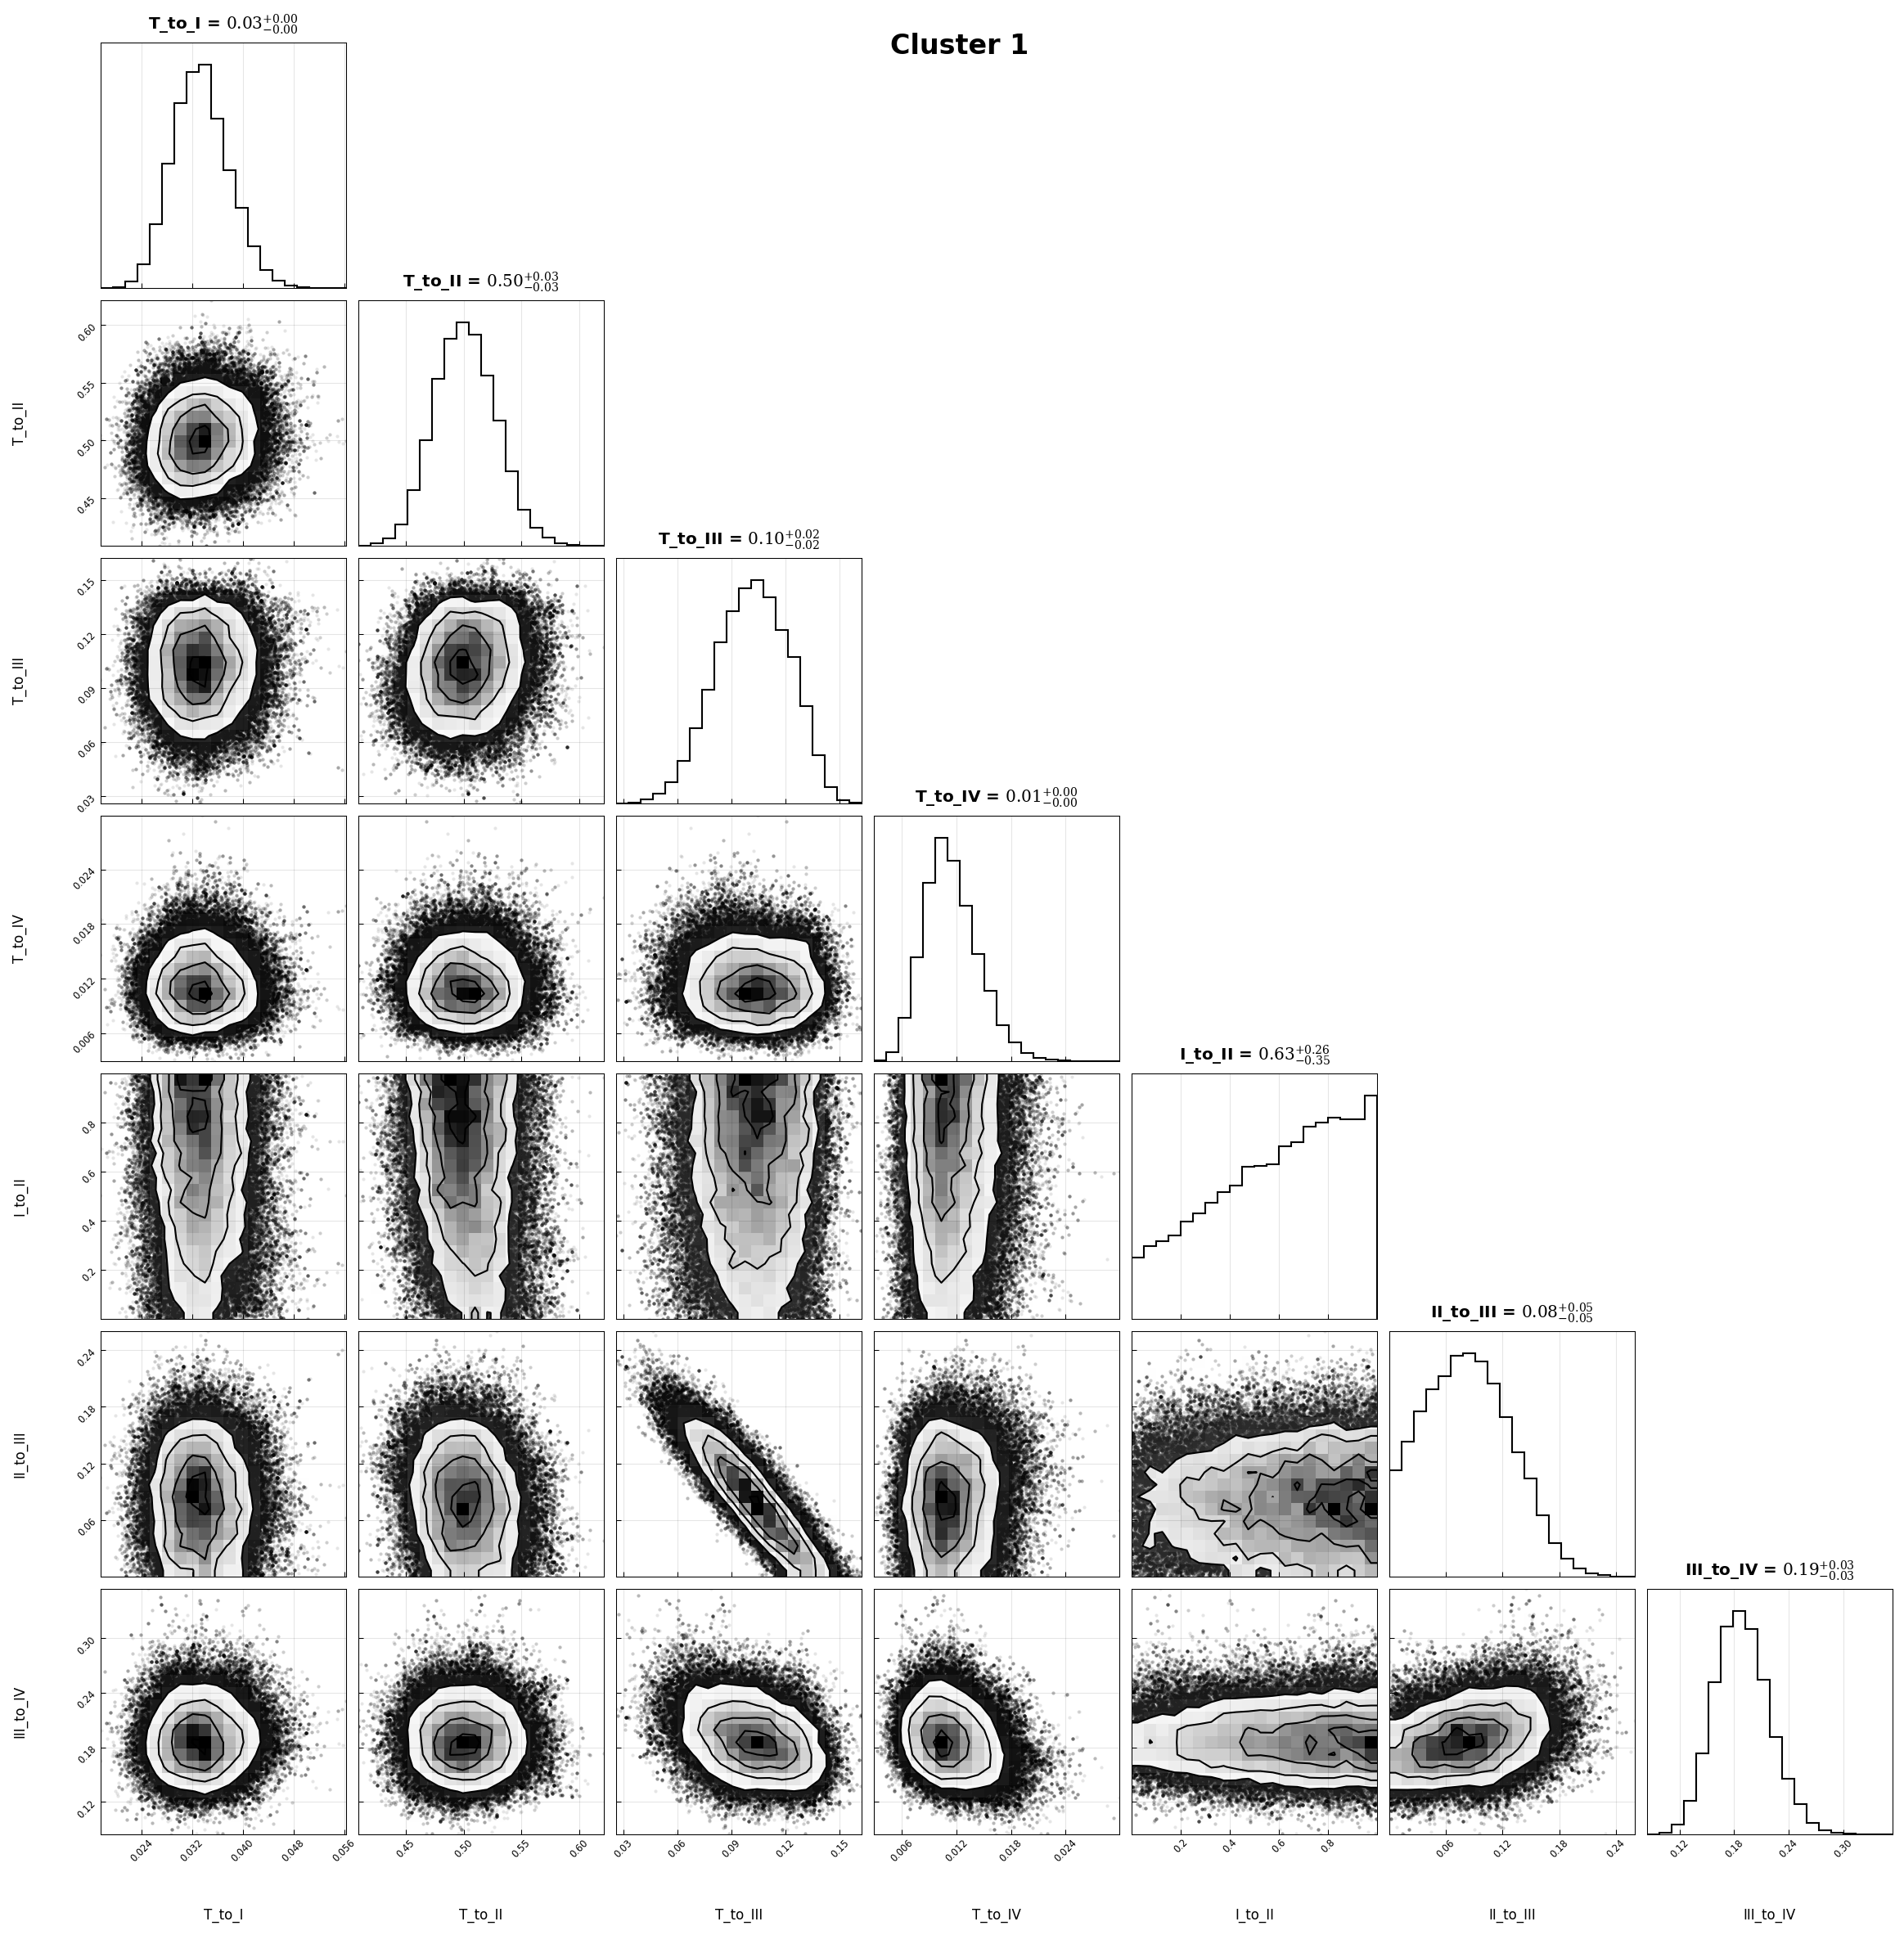

In [55]:
# .. and the new cluster parameters
LMM.plot_cluster_parameters()

### 3.2 Make predictions for single ICD code

In [25]:
# Either choose a label for which you want to make predictions, or choose a cluster assignment for other ICD code

 
label = "C05"
cluster_assignment_s1 = LMM.get_cluster_assignment_for_label(label)
print(f"The cluster assignment for {label} is: {cluster_assignment_s1}")


The cluster assignment for C05 is: [0.5195552 0.4804448]


In [26]:
# Now we can use the model to predict prevalences for a given pattern
for_pattern = {"ipsi": {'I': True, 'II': False, 'III': False}}



with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    print(LMM.predict_prevalence_for_cluster_assignment(cluster_assignment_s1, for_pattern, t_stage = 'all'))

0.05417042806181979


In [27]:
# .. or calculate the risk given an diagnose
# TODO doesnt work i guess
involvement = {"I": False}
given_diagnose = {"ipsi": {'I': True, 'II': False, 'III': False, "IV": False}}
given_diagnose_spsn = [0.76, 0.81]
LMM.predict_risk(cluster_assignment_s1, involvement, t_stage='all', given_diagnosis=given_diagnose, given_diagnosis_spsn=given_diagnose_spsn)

0.9999999999999998

### 3.3 Create Full Result Dataframe 

In [62]:
states_all = create_states(lnls_full)

In [63]:

for loc in location_to_include:
    logger.info(f"Creating result data for {loc}")
    # Create the loc model and load the independet samples
    model = create_models(1, graph, ignore_t_stage=ignore_t)
    model.load_patient_data(
        dataset[loc_to_mask[loc]], mapping=lambda x: convert_t_stage[x], side="ipsi"
    )
    models_loc[loc] = model
    # n_params = len(model.get_params())
    sample_name = Path(
        f"samples_ind_{loc}_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
    )
    output_dir = SAMPLE_PATH / sample_name
    if output_dir.with_suffix(".npy").exists():
        sampling_results = np.load(output_dir.with_suffix(".npy"))
    else:
        raise ValueError()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        c = LMM.create_result_df(
            states_all,
            lnls_full,
            labels=loc_to_icds_model[loc],
            independent_model=model,
            independent_model_samples=sampling_results,
            save_name=f"test_{loc}",
        )

2024-01-17 18:25:40,210 - __main__ - INFO - Creating result data for oral cavity


2024-01-17 18:25:40,297 - core.mixture_model - INFO - Computing for C02
2024-01-17 18:25:40,338 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-17 18:25:40,538 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-17 18:25:40,618 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-17 18:25:40,695 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-17 18:25:40,764 - co

### 3.4 Plot Results (e.g. Histogram prevalece plots)

In [54]:
color = {
    "red": "#ae0060",
    "blue": "#005ea8",
    "green": "#00afa5",
    "orange": "#f17900",
    "gray": "#c5d5db",
}

In [55]:
# We need the indpendent sample chains.
sample_name = (
    f"samples_ind_oral cavity_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
)
sample_dir = SAMPLE_PATH / sample_name
samples_oc = np.load(sample_dir.with_suffix(".npy"))

sample_name = (
f"samples_ind_oropharynx_{convert_lnl_to_filename(lnls_full)}_{ignore_t}"
)
sample_dir = SAMPLE_PATH / sample_name
samples_op = np.load(sample_dir.with_suffix(".npy"))

In [56]:
import random
import warnings
from core.mm_predict import _create_obs_pred_df_single, generate_predicted_prevalences_for_mixture
from lyscripts.predict.prevalences import compute_observed_prevalence

def compare_model_predictions(for_label, t_stage, patterns, n_predictions, LMM, dataset, icd_to_masks, lymph_model_for_mixture, n_clusters, lnls_full, models_loc, loc_to_mask, color, plot_path):
    # Retrieve cluster assignment
    cluster_assignment = LMM.get_cluster_assignment_for_label(for_label)

    # Prepare data
    data = dataset[icd_to_masks[for_label]]
    random_idx = random.sample(range(LMM.cluster_parameters_chain.shape[0]), n_predictions)
    samples_label = [LMM.cluster_parameters_chain[i, :] for i in random_idx]

    # Compute observed and predicted prevalences
    mm_data = {}
    for pattern in patterns:
        op = compute_observed_prevalence(pattern={"ipsi": pattern}, data=data, t_stage=t_stage, lnls=lnls_full)
        pp_list = list(generate_predicted_prevalences_for_mixture(pattern={"ipsi": pattern},
                                                                model=lymph_model_for_mixture,
                                                                n_clusters=n_clusters,
                                                                cluster_assignment=cluster_assignment,
                                                                samples=samples_label,
                                                                t_stage=t_stage))
        mm_data[str(pattern)]= (pp_list, op)    

    # Prepare data for histograms
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df_oc, oc_list = _create_obs_pred_df_single(samples_oc, models_loc["oral cavity"], dataset[loc_to_mask["oral cavity"]], patterns, lnls_full, n_samples=n_predictions)
        df_op, op_list = _create_obs_pred_df_single(samples_op, models_loc["oropharynx"], dataset[loc_to_mask["oropharynx"]], patterns, lnls_full, n_samples=n_predictions)

    # Plot histograms
    loc = for_label
    data = {f"{for_label}_MM": mm_data, 'Oral Cavity': oc_list[3][t_stage], 'Oropharynx': op_list[3][t_stage]}
    plot_histograms(data,patterns, single_line=True, colors=color, loc=loc, plot_path = plot_path)


2024-01-18 09:46:03,780 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


2024-01-18 09:46:04,138 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:04,477 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:04,804 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


Set up figure
Plotted 3 histograms


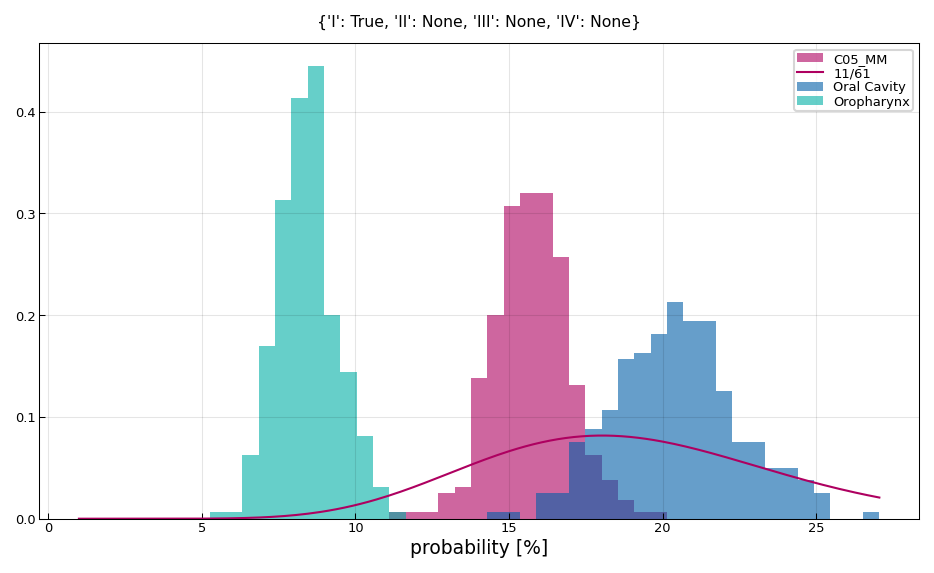

Set up figure
Plotted 3 histograms


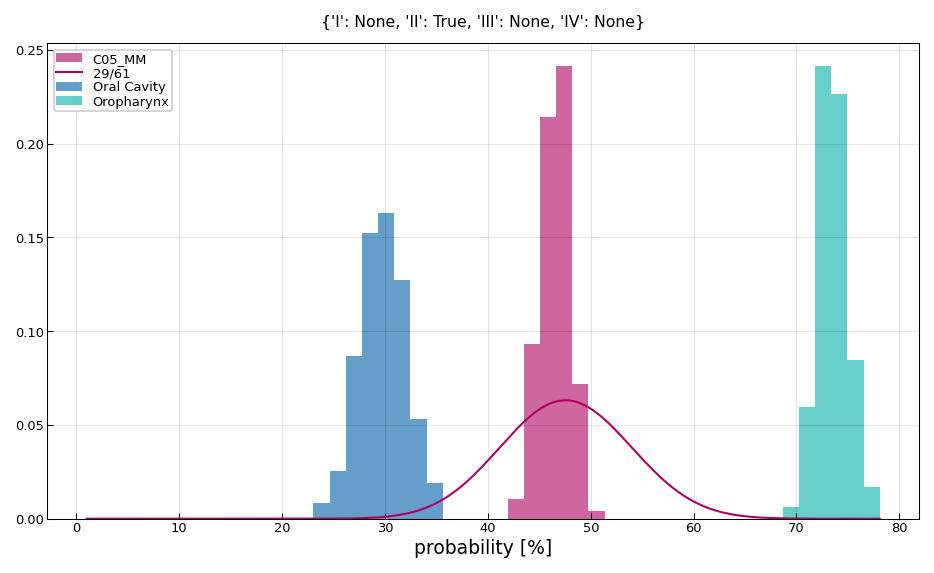

Set up figure
Plotted 3 histograms


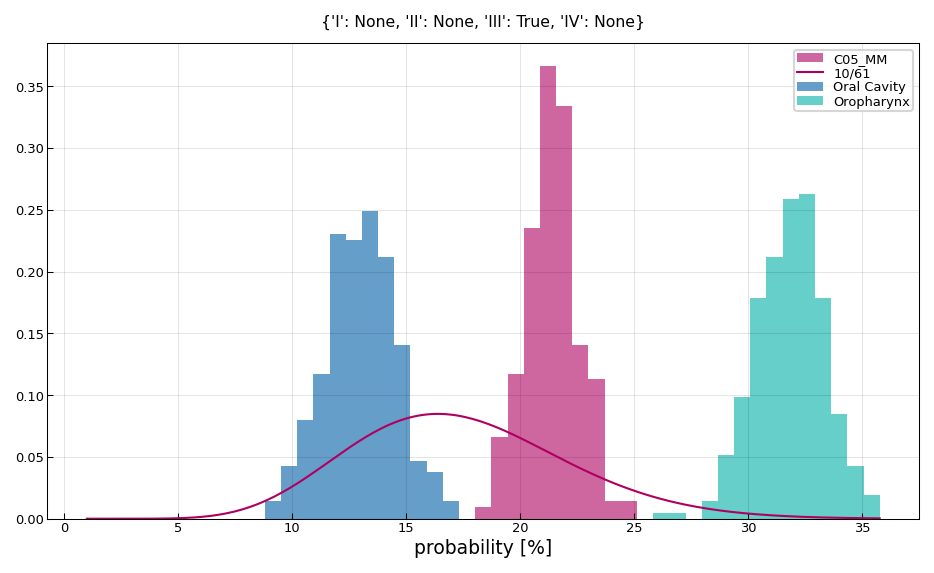

Set up figure
Plotted 3 histograms


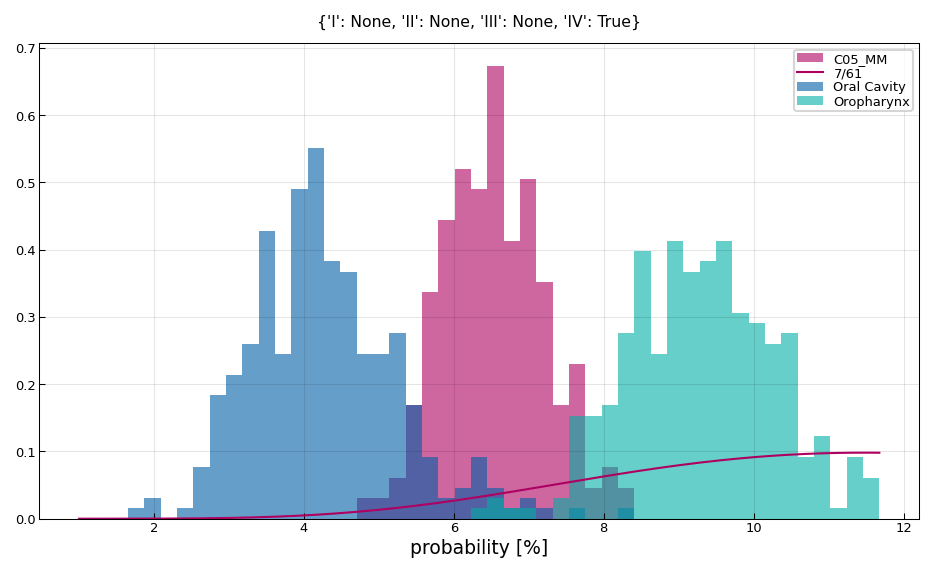

In [57]:
parameters_dict = {
    "LMM": LMM,
    "dataset": dataset,
    "icd_to_masks": icd_to_masks,
    "lymph_model_for_mixture": lymph_model_for_mixture,
    "n_clusters": n_clusters,
    "lnls_full": lnls_full,
    "models_loc": models_loc,
    "loc_to_mask": loc_to_mask,
    "color": color,
    "plot_path": PLOT_PATH 
}

for_label = "C05"
t_stage = "all"
patterns = [
    {"I": True, "II": None, "III": None, "IV": None},
    {"I": None, "II": True, "III": None, "IV": None},
    {"I": None, "II": None, "III": True, "IV": None},
    {"I": None, "II": None, "III": None, "IV": True},
]
n_predictions = 300


compare_model_predictions(
    for_label=for_label,
    t_stage=t_stage,
    patterns=patterns,
    n_predictions=n_predictions,
    **parameters_dict
)

2024-01-18 09:46:20,512 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


2024-01-18 09:46:20,869 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:21,200 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:21,574 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


Set up figure
Plotted 3 histograms


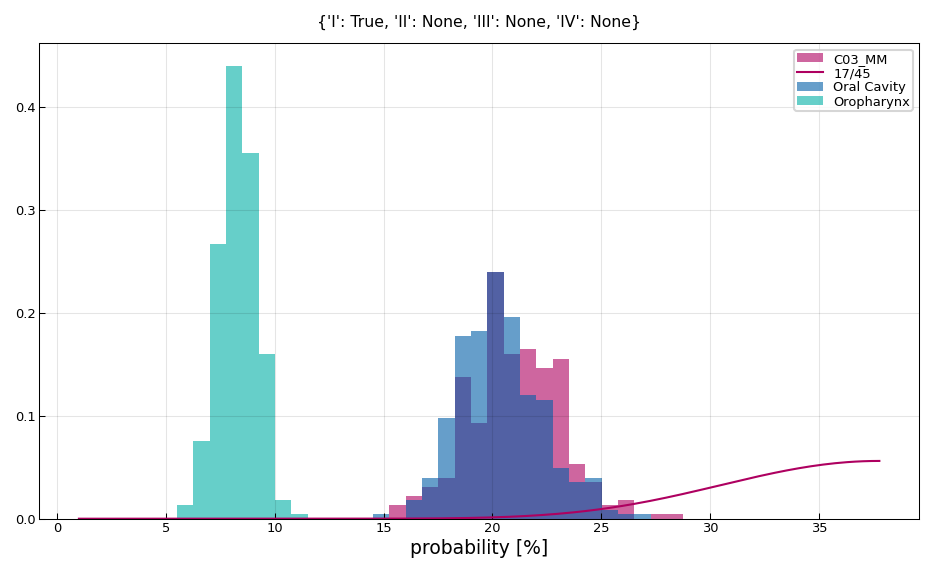

Set up figure
Plotted 3 histograms


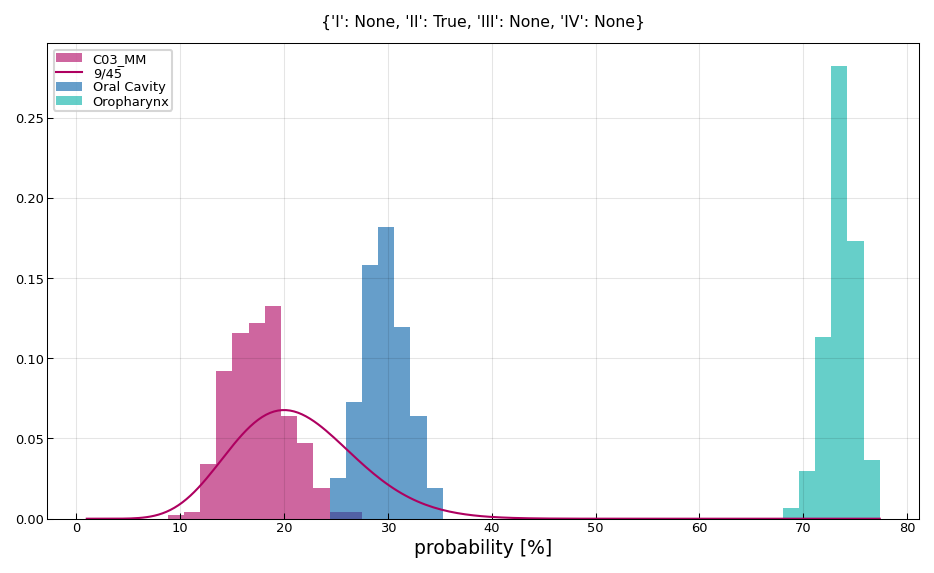

Set up figure
Plotted 3 histograms


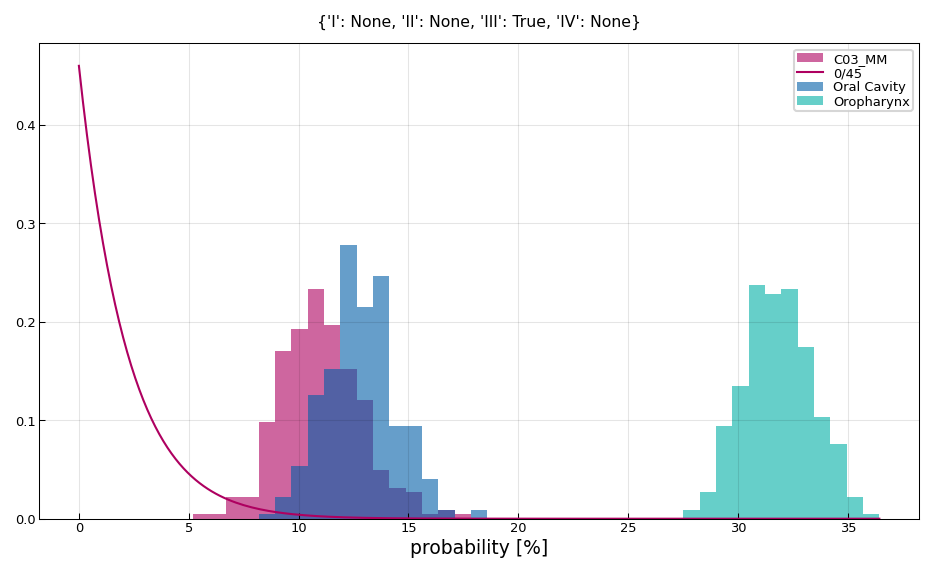

Set up figure
Plotted 3 histograms


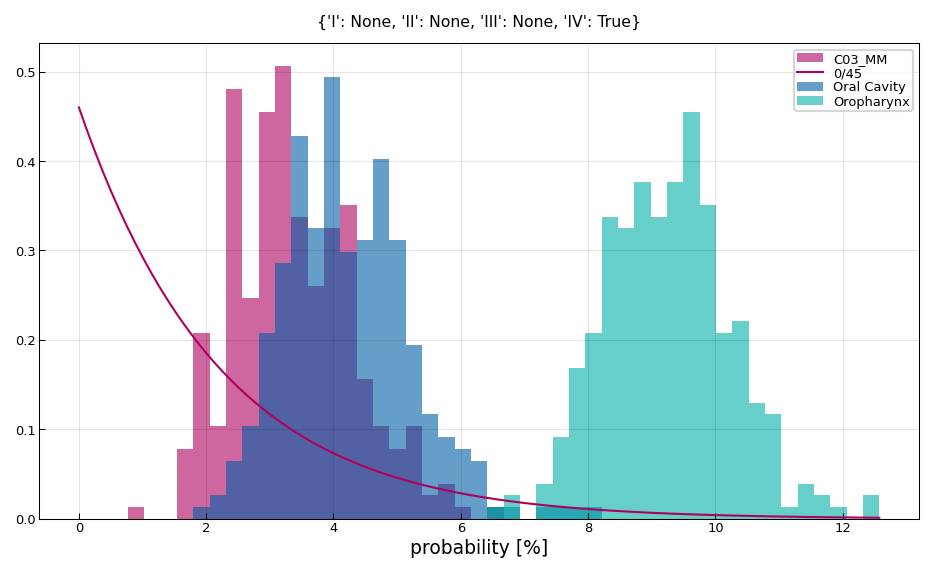

In [58]:

for_label = "C03"
t_stage = "all"
patterns = [
    {"I": True, "II": None, "III": None, "IV": None},
    {"I": None, "II": True, "III": None, "IV": None},
    {"I": None, "II": None, "III": True, "IV": None},
    {"I": None, "II": None, "III": None, "IV": True},
]
n_predictions = 300


compare_model_predictions(
    for_label=for_label,
    t_stage=t_stage,
    patterns=patterns,
    n_predictions=n_predictions,
    **parameters_dict
)

2024-01-18 09:46:26,374 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:26,826 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:27,195 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:27,554 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


Set up figure
Plotted 3 histograms


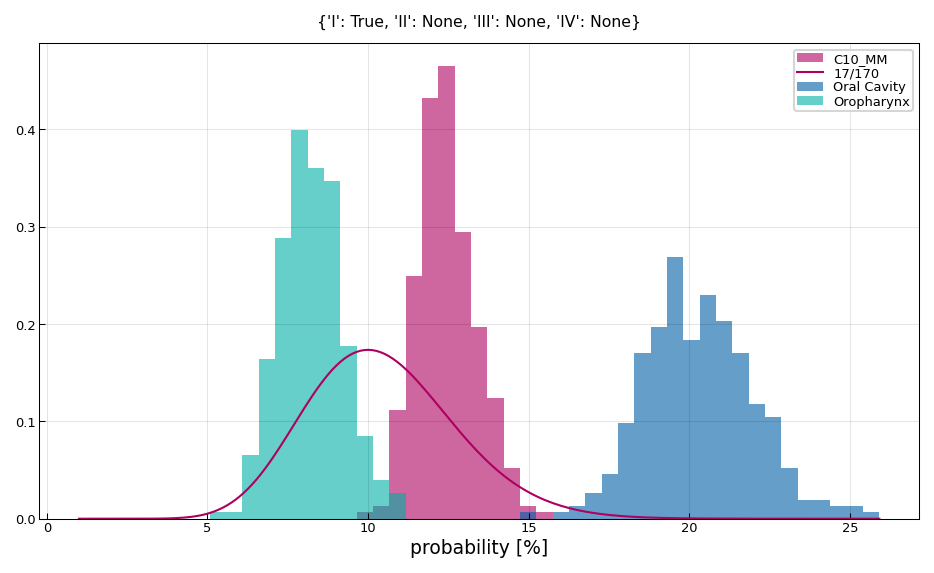

Set up figure
Plotted 3 histograms


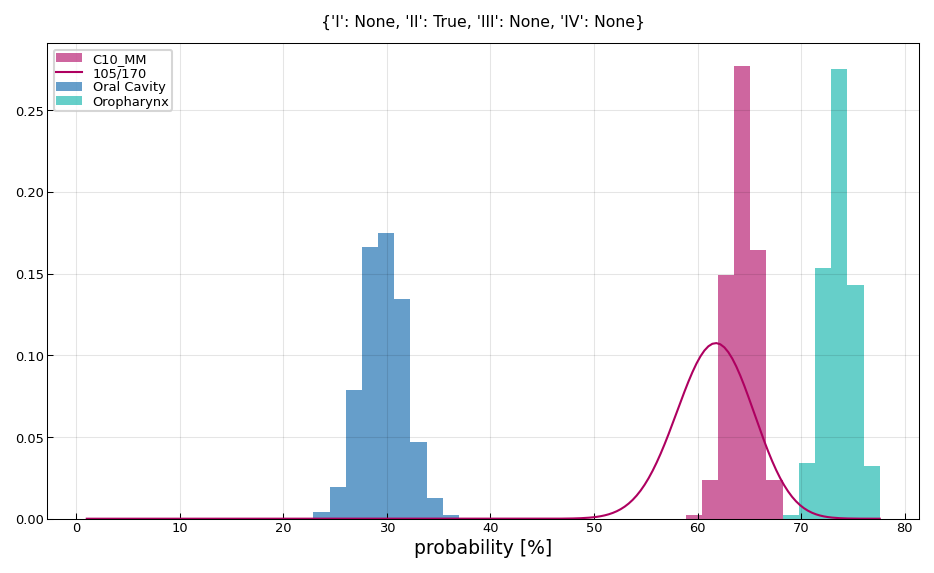

Set up figure
Plotted 3 histograms


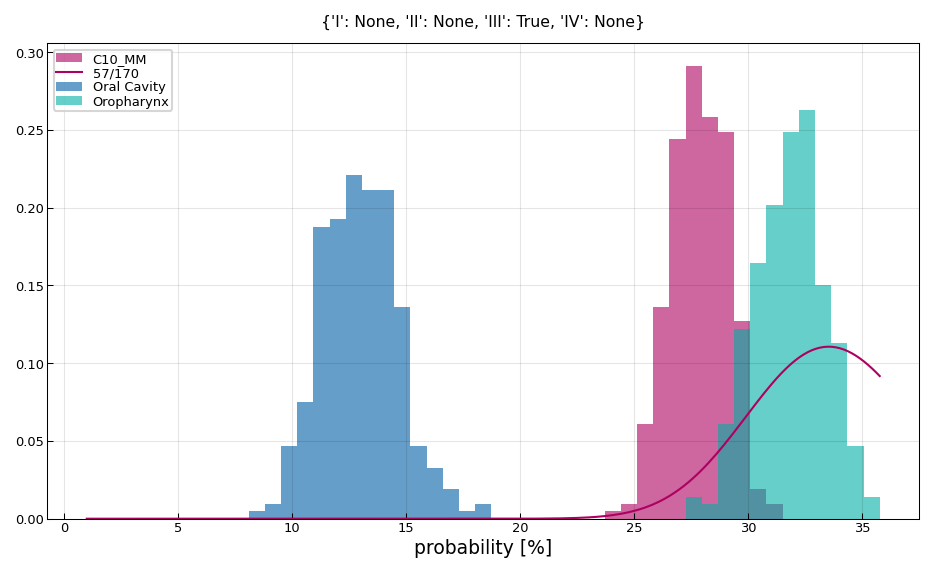

Set up figure
Plotted 3 histograms


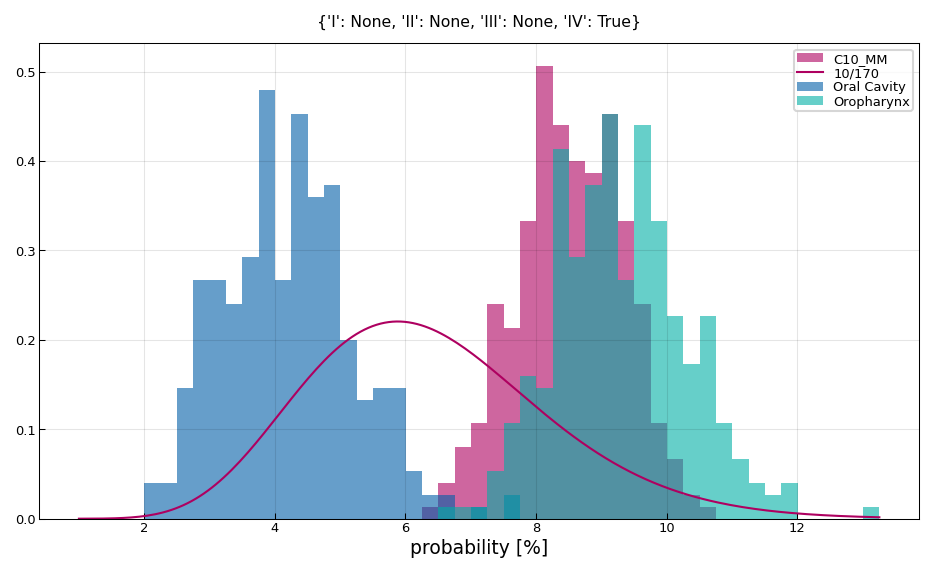

In [59]:

for_label = "C10"
t_stage = "all"
patterns = [
    {"I": True, "II": None, "III": None, "IV": None},
    {"I": None, "II": True, "III": None, "IV": None},
    {"I": None, "II": None, "III": True, "IV": None},
    {"I": None, "II": None, "III": None, "IV": True},
]
n_predictions = 300


compare_model_predictions(
    for_label=for_label,
    t_stage=t_stage,
    patterns=patterns,
    n_predictions=n_predictions,
    **parameters_dict
)

2024-01-18 09:46:32,423 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:32,898 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:33,264 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM
2024-01-18 09:46:33,797 - core.mixture_model - INFO - Create LymphMixtureModel of type <class 'lymph.models.unilateral.Unilateral'> with 2 clusters in /Users/juli/Studium/Master/FS23/masterthesis/code/lysubsite/notebooks/LMM


Set up figure
Plotted 3 histograms


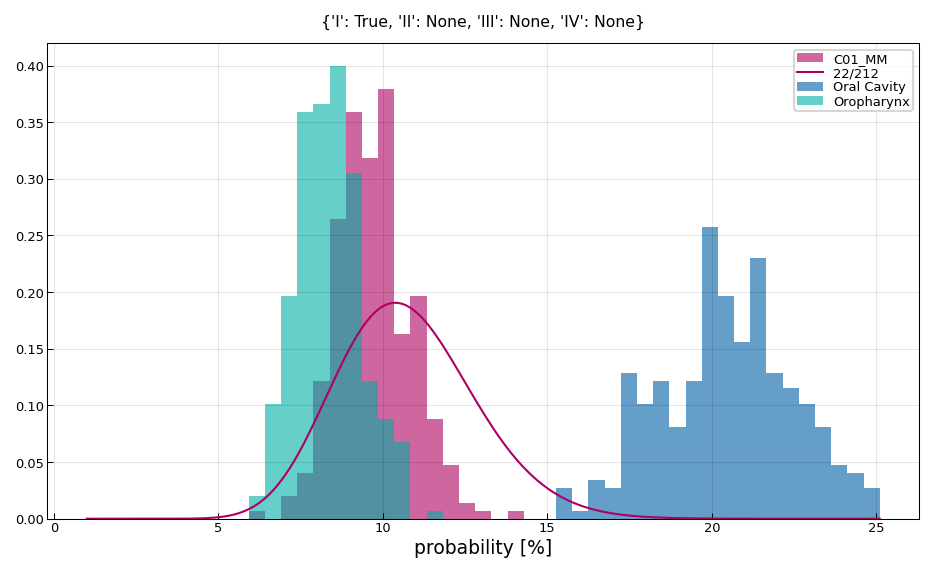

Set up figure
Plotted 3 histograms


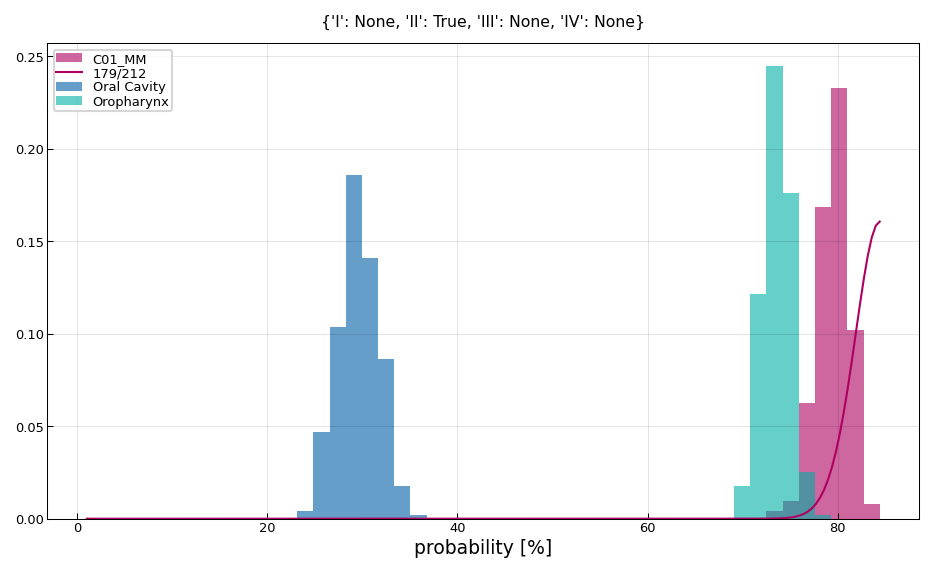

Set up figure
Plotted 3 histograms


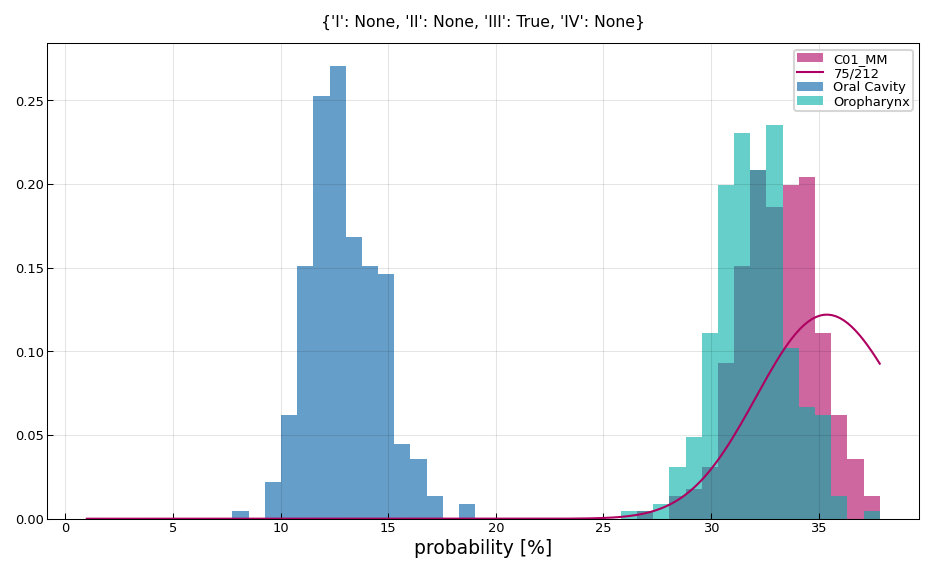

Set up figure
Plotted 3 histograms


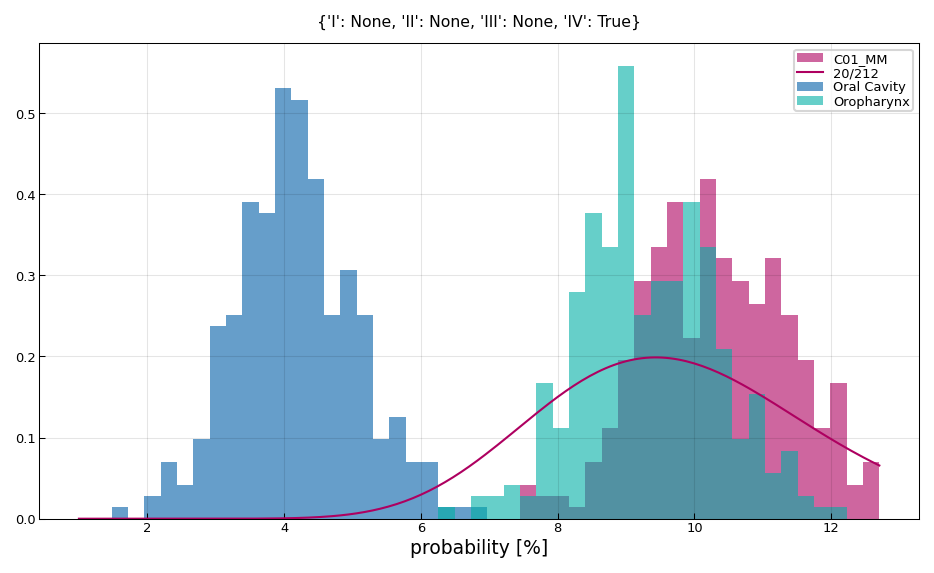

In [60]:

for_label = "C01"
t_stage = "all"
patterns = [
    {"I": True, "II": None, "III": None, "IV": None},
    {"I": None, "II": True, "III": None, "IV": None},
    {"I": None, "II": None, "III": True, "IV": None},
    {"I": None, "II": None, "III": None, "IV": True},
]
n_predictions = 300


compare_model_predictions(
    for_label=for_label,
    t_stage=t_stage,
    patterns=patterns,
    n_predictions=n_predictions,
    **parameters_dict
)

## 4. Additional Stuff (Plots etc)

In [98]:
import plotly.graph_objects as go
import itertools

# TODO add colors
# Define stuff for the flow chart

icd_codes_models_flat = list(chain(*loc_to_icds_model.values()))
nodes_all = [*location_to_include, *icd_codes_models_flat, *[f"Cluster {k}" for k in range(n_clusters)]]
colors_for_plot = [color_map[loc] for loc in location_to_include]

# 
sources_lv1 = list(itertools.chain.from_iterable([[i]*len(loc_to_icds_model[loc]) for (i, loc) in enumerate(location_to_include)]))

targets_lv1 = list(range(len(location_to_include),len(location_to_include) + len(icd_codes_models_flat),1))

sizes_lv1 = [icd_to_masks[icd].sum() for icd in icd_codes_models_flat]

targets_lv2 = list(chain(*[[len(nodes_all)-k]*len(targets_lv1) for k in range(n_clusters)][::-1]))

sizes_lv2 = list(chain(*[LMM.cluster_assignment_matrix[:,k]*sizes_lv1 for k in range(n_clusters)]))

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes_all,
      color = colors_for_plot
    ),
    link = dict(
      source = list(chain(*[sources_lv1, *[targets_lv1]*n_clusters])), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = list(chain(*[targets_lv1, *[targets_lv2]*n_clusters])),
      value = list(chain(*[sizes_lv1, sizes_lv2]))
  ))])
fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

